# Содержание

1. **Подготовка**
   - 1.1 Подготовка данных (EDA)
   - 1.2 Подготовка к обучению

2. **Обучение моделей**
   - 2.1 LinearRegression
   - 2.2 LightGBM
   - 2.3 Random Forest
   - 2.4 CatBoost

3. **Анализ моделей**

4. **Вывод**



## Подготовка

### 1.1 Подготовка данных (EDA)

In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # Прогресс-бар для циклов
import warnings

# Отключаем предупреждения
warnings.filterwarnings('ignore')

# Метрики и предобработка данных
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder

# Линейные модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Сложные модели
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# Табличное отображение
from tabulate import tabulate

# Таймер
import time


In [2]:
df = pd.read_csv('data.csv')

In [3]:
def check(df):

    print(df.head())
    
    print("\n" + "=" * 50)
    print("Информация о таблице:")
    print(df.info())
    
    print("\n" + "=" * 50)
    print("Описание данных (числовые столбцы):")
    print(tabulate(df.describe().T, headers="keys", tablefmt="grid"))
    
    print("\n" + "=" * 50)
    print("Процент пропусков в каждом столбце:")
    na_data = pd.DataFrame(
        round((df.isna().mean() * 100), 2),
        columns=['NaNs, %']
    ).sort_values(by='NaNs, %', ascending=False)
    print(tabulate(na_data, headers="keys", tablefmt="grid"))
    
    print("\n" + "=" * 50)
    print("Количество дупликатов в таблице:")
    print(f"{df.duplicated().sum()} дубликатов")
    
    print("\n" + "=" * 50)


 

In [4]:
len1 = len(df)

In [5]:
check(df)

   Unnamed: 0                                            url_car car_make  \
0           0  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth   
1           1  https://auto.ru/cars/used/sale/abarth/500/1118...   Abarth   
2           2  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth   
3           3  https://auto.ru/cars/used/sale/abarth/500/1124...   Abarth   
4           4  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth   

  car_model       car_gen       car_type           car_compl    ann_date  \
0       500  I Рестайлинг      Кабриолет   1.4 MT (180 л.с.)  2024-10-30   
1       500             I      Кабриолет   1.4 MT (135 л.с.)  2024-03-17   
2       500  I Рестайлинг      Кабриолет  1.4 AMT (180 л.с.)  2024-09-19   
3       500             I  Хэтчбек 3 дв.   1.4 MT (135 л.с.)  2024-08-15   
4       500  I Рестайлинг  Хэтчбек 3 дв.   1.4 AT (159 л.с.)  2024-10-14   

       ann_id  car_price  ... rear_brakes max_speed acceleration  fuel_cons  \
0

In [6]:
# Удаляем ненужный столбец Unnamed: 0, убераем ";" из cyl_count, а также удаляем лишние символы  из cyl_count.
df.drop("Unnamed: 0" , axis='columns', inplace=True, errors='ignore')
df = df.rename(columns={'cyl_count;': 'cyl_count'})


In [7]:

# Делаем отображения всех столбцов DataFrame
pd.set_option('display.max_columns', None)


In [8]:
# Анализ пропусков
na_summary = df.isnull().sum().sort_values(ascending=False)
print(na_summary[na_summary > 0])
# Анализ дубликатов
duplicate_summary = df.duplicated().sum()

print(na_summary[na_summary > 0], duplicate_summary)

eng_power_kw    99139
pow_resrv       99139
fuel_cons       13703
gross_weight    13056
v_bag            7410
acceleration     7282
max_speed        4971
v_tank           2862
curb_weight      2822
clearence        2715
engine_loc2      2593
fuel_brand       2052
engine_loc1      1695
turbocharg       1656
eng_size         1586
cyl_count        1586
rear_brakes      1378
max_torq          506
original_pts      422
class_auto        360
options             9
dtype: int64
eng_power_kw    99139
pow_resrv       99139
fuel_cons       13703
gross_weight    13056
v_bag            7410
acceleration     7282
max_speed        4971
v_tank           2862
curb_weight      2822
clearence        2715
engine_loc2      2593
fuel_brand       2052
engine_loc1      1695
turbocharg       1656
eng_size         1586
cyl_count        1586
rear_brakes      1378
max_torq          506
original_pts      422
class_auto        360
options             9
dtype: int64 0


In [9]:
# Удаление дубликатов
df = df.drop_duplicates()

# Удаление столбцов с более чем 90% пропусков
columns_to_drop = df.columns[df.isnull().mean() > 0.9]
df = df.drop(columns=columns_to_drop)
check(df)

                                             url_car car_make car_model  \
0  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth       500   
1  https://auto.ru/cars/used/sale/abarth/500/1118...   Abarth       500   
2  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth       500   
3  https://auto.ru/cars/used/sale/abarth/500/1124...   Abarth       500   
4  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth       500   

        car_gen       car_type           car_compl    ann_date      ann_id  \
0  I Рестайлинг      Кабриолет   1.4 MT (180 л.с.)  2024-10-30  1125082098   
1             I      Кабриолет   1.4 MT (135 л.с.)  2024-03-17  1118403975   
2  I Рестайлинг      Кабриолет  1.4 AMT (180 л.с.)  2024-09-19  1125077090   
3             I  Хэтчбек 3 дв.   1.4 MT (135 л.с.)  2024-08-15  1124579446   
4  I Рестайлинг  Хэтчбек 3 дв.   1.4 AT (159 л.с.)  2024-10-14  1125453984   

   car_price         ann_city  \
0    2700000          Обнинск   
1    1400000  

In [10]:
# Вывод одинаковых 'ann_id' с количеством повторений
duplicated_ids_count = df['ann_id'].value_counts()

# Вывод результатов
print("Количество повторений для каждого 'ann_id':")
print(duplicated_ids_count.head(10))  # Топ-10 самых частых повторений

# Уникальные ID, которые повторяются
repeated_ids = duplicated_ids_count.index
print("\nПримеры одинаковых 'ann_id':")
print(repeated_ids[:10])  # Топ-10 повторяющихся ID





Количество повторений для каждого 'ann_id':
ann_id
1125082098    1
1125020784    1
1124808823    1
1125021425    1
1124589895    1
1125960178    1
1118219228    1
1125668377    1
1123912099    1
1125694054    1
Name: count, dtype: int64

Примеры одинаковых 'ann_id':
Index([1125082098, 1125020784, 1124808823, 1125021425, 1124589895, 1125960178,
       1118219228, 1125668377, 1123912099, 1125694054],
      dtype='int64', name='ann_id')


In [11]:
# Вывод детальной информации для всех записей с дублирующимися 'ann_id'
example_id = duplicated_ids_count.index[0]  # Берем первый повторяющийся ID
details_for_id = df[df['ann_id'] == example_id]

# Вывод результатов
print(f"Детальная информация для 'ann_id' = {example_id}:")
print(details_for_id)

# Удаление дубликатов по 'ann_id', оставляя последнюю запись по дате
df = df.drop_duplicates()  # Удаление полных дубликатов
df = df.sort_values(by='ann_date')  # Сортировка по дате
df = df.drop_duplicates(subset='ann_id', keep='last')  # Удаление дубликатов по 'ann_id'

# Проверка результата
print(f"Количество строк до очистки: {len(df)}")
print(f"Количество строк после удаления полных дубликатов: {len(df)}")
print(f"Количество строк после удаления дублей 'ann_id': {len(df)}")




Детальная информация для 'ann_id' = 1125082098:
                                             url_car car_make car_model  \
0  https://auto.ru/cars/used/sale/abarth/500/1125...   Abarth       500   

        car_gen   car_type          car_compl    ann_date      ann_id  \
0  I Рестайлинг  Кабриолет  1.4 MT (180 л.с.)  2024-10-30  1125082098   

   car_price ann_city                                           link_cpl  \
0    2700000  Обнинск  https://auto.ru/catalog/cars/abarth/500/240056...   

       avail  year  mileage        color  eng_size  eng_power eng_type  \
0  В наличии  2020    44000  серебристый       1.4        180   Бензин   

   options  transmission     drive st_wheel           condition count_owner  \
0  1 опция  механическая  передний    Левый  Не требует ремонта  1 владелец   

  original_pts     customs                                          url_compl  \
0     Оригинал  Растаможен  https://auto.ru/catalog/cars/abarth/500/240056...   

  state_mark class_auto  door_

In [12]:

# Повторная очистка данных с корректировками
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.').str.replace(' ', '').str.strip()

# Преобразование числовых столбцов
try:
    for col in ['car_price', 'year', 'mileage', 'eng_size', 'eng_power', 'door_count',
                'seat_count', 'long', 'widht', 'height', 'clearence', 'v_bag', 'v_tank',
                'curb_weight', 'gross_weight', 'max_speed', 'acceleration', 'fuel_cons', 
                'max_torq', 'cyl_count']:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Преобразование строк в float
except ValueError as e:
    print('{col}: {e}')

# Преобразование единиц измерения
df['mileage'] = df['mileage'] / 1000  # Пробег в тысячах километров
df['long'] = df['long'] / 1000  # Длина в метрах
df['widht'] = df['widht'] / 1000  # Ширина в метрах
df['height'] = df['height'] / 1000  # Высота в метрах
df['curb_weight'] = df['curb_weight'] / 1000  # Вес в тоннах
df['gross_weight'] = df['gross_weight'] / 1000  # Полный вес в тоннах
df['clearence'] = df['clearence'] / 10  # Клиренс в сантиметрах

# Преобразование даты
df['ann_date'] = pd.to_datetime(df['ann_date'], errors='coerce')



df.head(3)



,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,engine_loc1,engine_loc2,turbocharg,max_torq,cyl_count
90596,https://auto.ru/cars/used/sale/uaz/3151/112181...,УАЗ,3151,1985-2013,Внедорожник5дв.,315192.9MT(84л.с.)4WD,2024-01-01,1121811096,500000,Чехов,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Вналичии,2005,125.000,серебристый,2.9,84,Бензин,2опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Россия,J,5,7,4.025,1.785,2.020,22.0,900.0,78.0,1.750,2.500,дисковые,барабанные,120.0,NaN,16.2,АИ-92,переднее,продольное,нет,189.0,4.0
63615,https://auto.ru/cars/used/sale/peugeot/308/112...,Peugeot,308,IРестайлинг,Хэтчбек5дв.,1.6AT(120л.с.),2024-01-01,1121810455,550000,Москва,https://auto.ru/catalog/cars/peugeot/308/73527...,Вналичии,2011,100.000,белый,1.6,120,Бензин,Allure,автоматическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/308/73527...,Франция,C,5,5,4.276,1.815,1.498,17.0,348.0,60.0,1.312,1.835,дисковые,дисковые,188.0,13.0,5.4,АИ-95,переднее,поперечное,нет,160.0,4.0
35146,https://auto.ru/cars/used/sale/kaiyi/e5/112181...,Kaiyi,E5,2021-н.в.,Седан,1.5CVT(147л.с.),2024-01-01,1121812001,1850000,Сочи,https://auto.ru/catalog/cars/kaiyi/e5/23390390...,Вналичии,2023,23.332,белый,1.5,147,Бензин,Luxury+,вариатор,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/kaiyi/e5/23390390...,Китай,C,4,5,4.670,1.825,1.483,16.0,450.0,50.0,1.441,1.797,дисковые,дисковые,210.0,10.5,NaN,АИ-92,переднее,поперечное,турбонаддув,210.0,4.0


Смотрим на столбцы с пропущенными значениями и обрабатываем их для дальнейшего удобства работы с данными

In [13]:
df[df['class_auto'].isnull()]
df['class_auto'].value_counts().reset_index()
df['class_auto'] = df['class_auto'].fillna('V')

Смотрим на отсутствует сведения о ПТС
Наиболее оптимальным видится замена нулевых значений на "Дубликат"

In [14]:
df[df['original_pts'].isnull()].head(10)

df['original_pts'] = df['original_pts'].fillna('Дубликат')

df['original_pts'].isnull().sum()

0

Заменим нулевые значения на средние по типу кузова автомобиля

In [15]:
df[df['clearence'].isnull()].head(10)
missing_clearence = df[df['clearence'].isnull()].head(10)

df['clearence'] = df['clearence'].fillna(df.groupby('class_auto')['clearence'].transform('mean'))

print(df['clearence'].isnull().sum())

0


Смотрим на строки без объема багажника. Заполнение пропусков в 'v_bag' значением 0

In [16]:
df[df['v_bag'].isnull()]
df['v_bag'] = df['v_bag'].fillna(0)

print(df['v_bag'].isnull().sum())

0


Смотрим на строки без объема бака. Заполняем пропуски в 'v_tank' значением 0 


In [17]:
df[df['v_tank'].isnull()].head(10)
df['v_tank'] = df['v_tank'].fillna(0)

print(df['v_tank'].isnull().sum())

0


Смотрим на строки без снаряженной массы. Меняем значения снаряженной массы на средние по классу автомобиля

In [18]:
df[df['curb_weight'].isnull()].head(10)
df['curb_weight'] = df['curb_weight'].fillna(df.groupby('class_auto')['curb_weight'].transform('mean'))

print(df['curb_weight'].isnull().sum())

0


Смотрим на строки без полной массы. Меняем значения полной массы на средние по классу автомобиля

In [19]:
df[df['gross_weight'].isnull()].head(10)
df['gross_weight'] = df['gross_weight'].fillna(df.groupby('class_auto')['gross_weight'].transform('mean'))

print(df['gross_weight'].isnull().sum())

0


 Смотрим на пропуски в 'rear_brakes' и  заполнение пропусков в 'rear_brakes'по такой логике:
 - если 'front_brakes' == 'дисковые', то 'rear_brakes' = 'дисковые',
 - иначе заполняем модой по 'class_auto'

In [20]:
brakes_class_auto = df.groupby('class_auto')['rear_brakes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

brakes_class_auto = brakes_class_auto.to_dict()

def fill_rear_brakes(row):
    if pd.isnull(row['rear_brakes']):
        if row['front_brakes'] == 'дисковые':
            return 'дисковые'
        elif row['class_auto'] in brakes_class_auto:
            return brakes_class_auto[row['class_auto']]
    return row['rear_brakes']

df['rear_brakes'] = df.apply(fill_rear_brakes, axis=1)

df['rear_brakes'].isnull().sum()


0

Cмотрим информации о столбцах 'max_speed' и 'acceleration' и заполнение пропусков средними значениями по группам 'class_auto'


In [21]:
df['max_speed'].describe()
df['acceleration'].describe()

df['max_speed'] = df['max_speed'].fillna(df.groupby('class_auto')['max_speed'].transform('mean'))
df['acceleration'] = df['acceleration'].fillna(df.groupby('class_auto')['acceleration'].transform('mean'))

print(df['max_speed'].isnull().sum(), df['acceleration'].isnull().sum())

0 0


Работаем с столбцом 'fuel_cons' 

Заполняем средними значениями по 'eng_type' и 'eng_size'. Для более редких моделей будем использвоать среднее по 'class_auto'.

Также делаем проверку

In [22]:
df['fuel_cons'] = df['fuel_cons'].fillna(df.groupby(['eng_type', 'eng_size'])['fuel_cons'].transform('mean'))
df['fuel_cons'] = df['fuel_cons'].fillna(df.groupby('class_auto')['fuel_cons'].transform('mean'))

print(df['fuel_cons'].isnull().sum())

0


Проверям где нам еще нужно провести корректировку 

Осталось Поработать с этими столбцами:

Процент пропусков в каждом столбце

| Столбец        | Пропусков, % |
|----------------|--------------|
| engine_loc2    | 3.16%        |
| fuel_brand     | 2.07%        |
| eng_size       | 2.04%        |
| cyl_count      | 2.04%        |
| turbocharg     | 2.03%        |
| engine_loc1    | 2.00%        |
| max_torq       | 0.68%        |
| original_pts   | 0.43%        |
| seat_count     | 0.10%        |
| options        | 0.04%        |


In [23]:
check(df)

                                                 url_car car_make  \
90596  https://auto.ru/cars/used/sale/uaz/3151/112181...      УАЗ   
63615  https://auto.ru/cars/used/sale/peugeot/308/112...  Peugeot   
35146  https://auto.ru/cars/used/sale/kaiyi/e5/112181...    Kaiyi   
30375  https://auto.ru/cars/used/sale/gaz/m_20/112181...      ГАЗ   
24079  https://auto.ru/cars/used/sale/exeed/vx/112181...    EXEED   

          car_model      car_gen         car_type              car_compl  \
90596          3151    1985-2013  Внедорожник5дв.  315192.9MT(84л.с.)4WD   
63615           308  IРестайлинг      Хэтчбек5дв.         1.6AT(120л.с.)   
35146            E5    2021-н.в.            Седан        1.5CVT(147л.с.)   
30375  М-20«Победа»    1946-1958          Фастбек          2.1MT(52л.с.)   
24079            VX            I  Внедорожник5дв.     2.0AMT(249л.с.)4WD   

        ann_date      ann_id  car_price ann_city  \
90596 2024-01-01  1121811096     500000    Чехов   
63615 2024-01-01  112181

In [24]:
# Заполнение числовых столбцов средними значениями по 'class_auto'
columns_to_fill_mean_extended = ['eng_size', 'max_torq', 'cyl_count']
for col in columns_to_fill_mean_extended:
    df[col] = df[col].fillna(df.groupby(['class_auto',])[col].transform('mean'))

print(df.isnull().sum())


url_car            0
car_make           0
car_model          0
car_gen            0
car_type           0
car_compl          0
ann_date           0
ann_id             0
car_price          0
ann_city           0
link_cpl           0
avail              0
year               0
mileage            0
color              0
eng_size           0
eng_power          0
eng_type           0
options            9
transmission       0
drive              0
st_wheel           0
condition          0
count_owner        0
original_pts       0
customs            0
url_compl          0
state_mark         0
class_auto         0
door_count         0
seat_count         0
long               0
widht              0
height             0
clearence          0
v_bag              0
v_tank             0
curb_weight        0
gross_weight       0
front_brakes       0
rear_brakes        0
max_speed          0
acceleration       0
fuel_cons          0
fuel_brand      2052
engine_loc1     1695
engine_loc2     2593
turbocharg   

Данные по расположению и ориентации двигателя разрознены, полагаю отказаться от их использования при построении модели.

In [25]:
df = df.drop(columns = ['engine_loc1'])
df = df.drop(columns = ['engine_loc2'])

Функция для заполнения 'fuel_brand' на основе типа двигателя, марки автомобиля и специальных условий

In [26]:
def fill_fuel_brand(row):
    if pd.isnull(row['fuel_brand']) or row['fuel_brand'] == 'unknown':
        if row['eng_type'] == 'Бензиновый':
            return 'АИ-95'
        elif row['eng_type'] == 'Дизельный':
            return 'ДТ'
        elif row['eng_type'] == 'Электрический':
            return 'Electro'
        elif row['car_make'] == 'Trabant':
            return 'АИ-80' 
        else:
            return 'unknown'  
    return row['fuel_brand']

df['fuel_brand'] = df.apply(fill_fuel_brand, axis=1)

# Проверка 
print(df['fuel_brand'].isnull().sum())

0


In [27]:
fuel_mapping = {
    'unknown': 'unknown',
    'АИ-95': 'gasoline',
    'АИ-92': 'gasoline',
    'АИ-98': 'gasoline',
    'АИ-80': 'gasoline',
    'АИ-76': 'gasoline',
    'ДТ': 'diesel',
    'Газ(Бензин)': 'gas',
}

df['fuel_brand'] = df['fuel_brand'].map(fuel_mapping)


df['fuel_brand'].isna().sum()

0

In [28]:
df['eng_type'].unique()

df['eng_type'] = df['eng_type'].replace({
    'Бензин.газобаллонноеоборудование': 'Бензин',
    'Газ.газобаллонноеоборудование': 'Газ',
    'Дизель.газобаллонноеоборудование': 'Дизель'})

print(df['eng_type'].unique())


['Бензин' 'Дизель' 'Электро' 'Гибрид' 'Газ'
 'Гибрид.газобаллонноеоборудование']


In [29]:
print(df['fuel_brand'].unique())

['gasoline' 'diesel' 'unknown' 'gas']


In [30]:
df[df['turbocharg'].isnull()].head()
df['turbocharg'].value_counts().reset_index()
df['turbocharg'] = df['turbocharg'].fillna('нет')

print(df['turbocharg'].isnull().sum())

0


In [31]:
df.loc[(df['fuel_brand'] == 'unknown') & (df['car_compl'].str.contains('Electro', na=False)), 'fuel_brand'] = 'Electro'
df.loc[df['fuel_brand'] == 'Electro', 'fuel_cons'] = 0

updated_fuel_brand_counts = df['fuel_brand'].value_counts()
updated_fuel_cons_summary = df[df['fuel_brand'] == 'Electro']['fuel_cons'].describe()

updated_fuel_brand_counts, updated_fuel_cons_summary


(fuel_brand
 gasoline    85654
 diesel      12988
 Electro      1586
 unknown       463
 gas            34
 Name: count, dtype: int64,
 count    1586.0
 mean        0.0
 std         0.0
 min         0.0
 25%         0.0
 50%         0.0
 75%         0.0
 max         0.0
 Name: fuel_cons, dtype: float64)

Заполнение пропусков в 'options' модой по группам 'class_auto'

In [32]:
df['options'] = df['options'].fillna(df.groupby('class_auto')['options'].transform('first'))

print(df['options'].isnull().sum())

0



Очищаем данные в seat_count, заполняет пропуски медианой по class_auto, затем средним значением

In [33]:
df['seat_count'] = df['seat_count'].astype(str).str.replace(',', '.').str.strip()
df['seat_count'] = pd.to_numeric(df['seat_count'], errors='coerce')


df['seat_count'] = df['seat_count'].fillna(df.groupby('class_auto')['seat_count'].transform('median'))
df['seat_count'] = df['seat_count'].fillna(df['seat_count'].mean())

print(df['seat_count'].isnull().sum())


0


In [34]:
check(df)

                                                 url_car car_make  \
90596  https://auto.ru/cars/used/sale/uaz/3151/112181...      УАЗ   
63615  https://auto.ru/cars/used/sale/peugeot/308/112...  Peugeot   
35146  https://auto.ru/cars/used/sale/kaiyi/e5/112181...    Kaiyi   
30375  https://auto.ru/cars/used/sale/gaz/m_20/112181...      ГАЗ   
24079  https://auto.ru/cars/used/sale/exeed/vx/112181...    EXEED   

          car_model      car_gen         car_type              car_compl  \
90596          3151    1985-2013  Внедорожник5дв.  315192.9MT(84л.с.)4WD   
63615           308  IРестайлинг      Хэтчбек5дв.         1.6AT(120л.с.)   
35146            E5    2021-н.в.            Седан        1.5CVT(147л.с.)   
30375  М-20«Победа»    1946-1958          Фастбек          2.1MT(52л.с.)   
24079            VX            I  Внедорожник5дв.     2.0AMT(249л.с.)4WD   

        ann_date      ann_id  car_price ann_city  \
90596 2024-01-01  1121811096     500000    Чехов   
63615 2024-01-01  112181

0it [00:00, ?it/s]

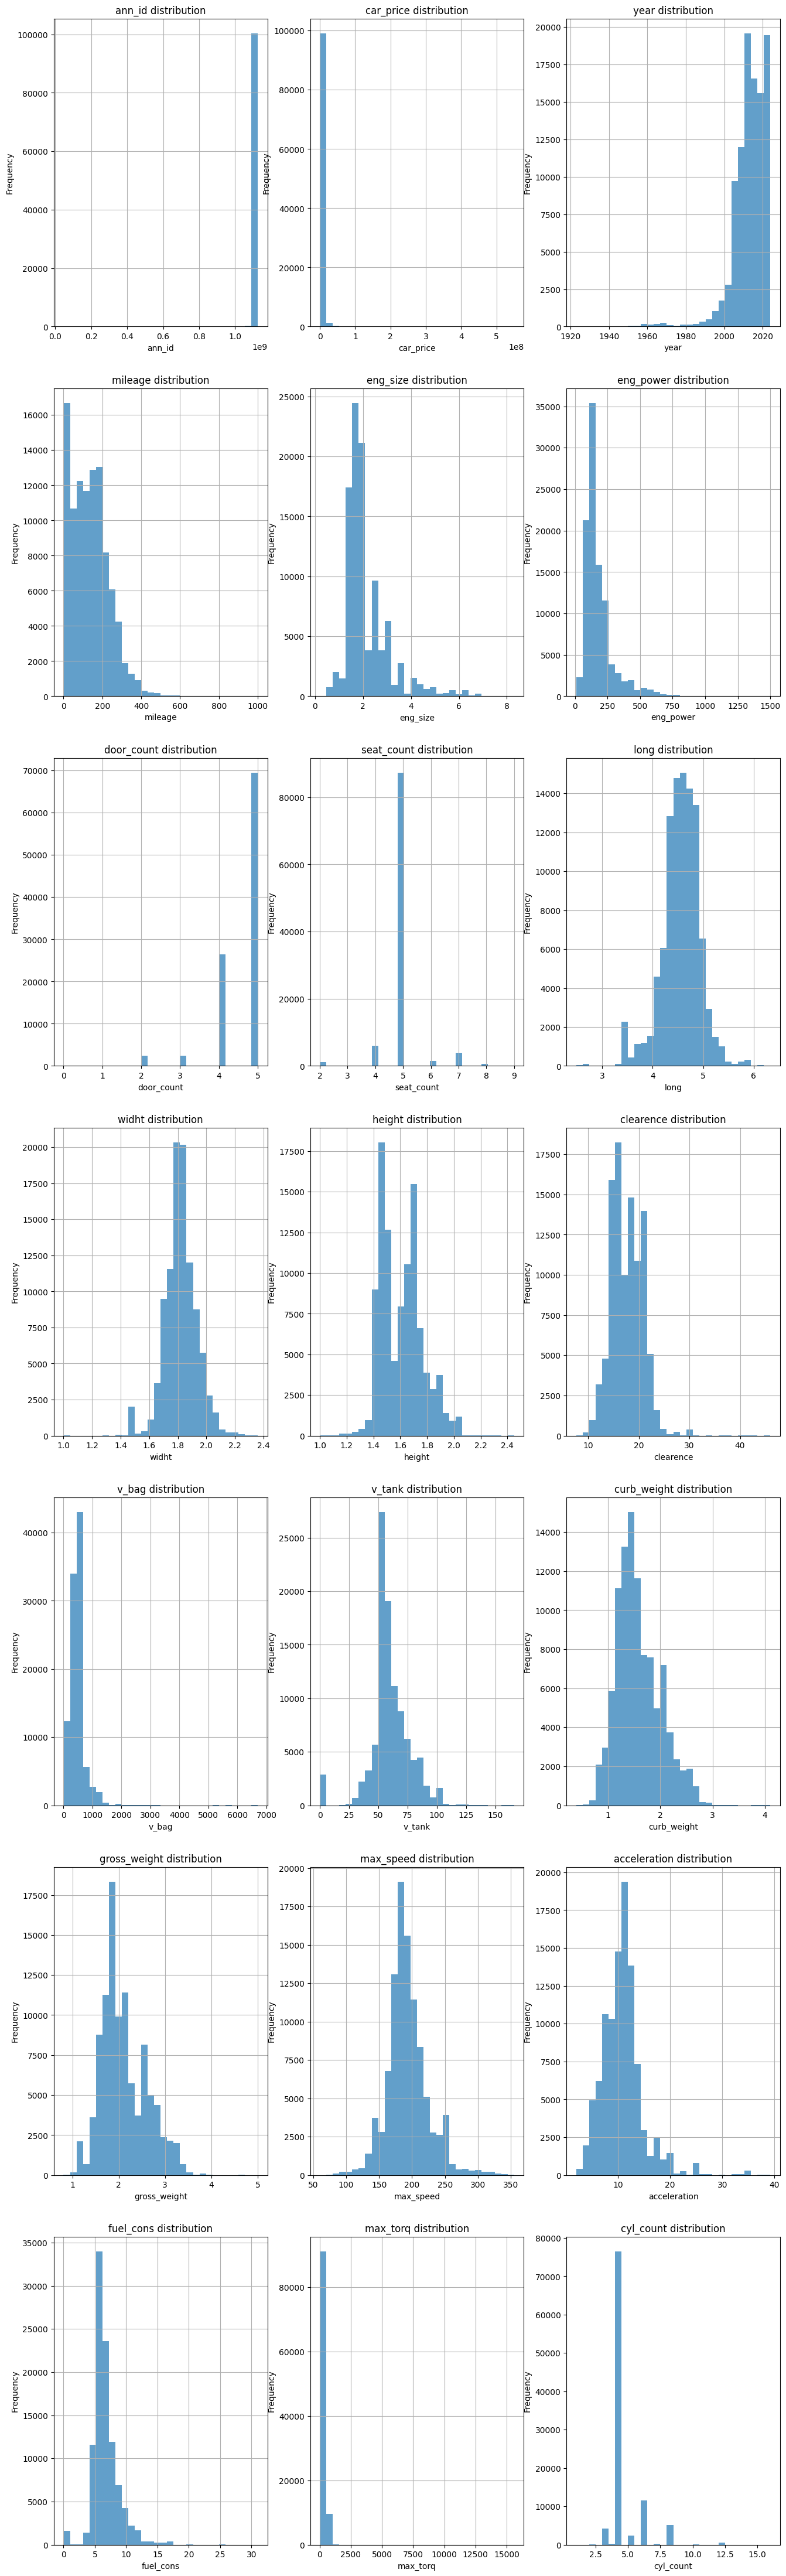

In [35]:
numeric_cols = df.select_dtypes([int, float]).columns
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 3) + (num_cols % 3), ncols=3, figsize=(16, (num_cols // 3 + 1) * 7))
for ax, col in tqdm(zip(axes.flatten(), numeric_cols)):
    ax.hist(df[col], bins=30, alpha=0.7)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid()

for i in range(num_cols, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.grid()
plt.show()

В данных наблюдается некоторое искажение: для пробега автомобиля преобладают значения близкие к нулю, возможно влиение параллельного импорта. Посмотрим на разброс данных по стране производства автомобиля

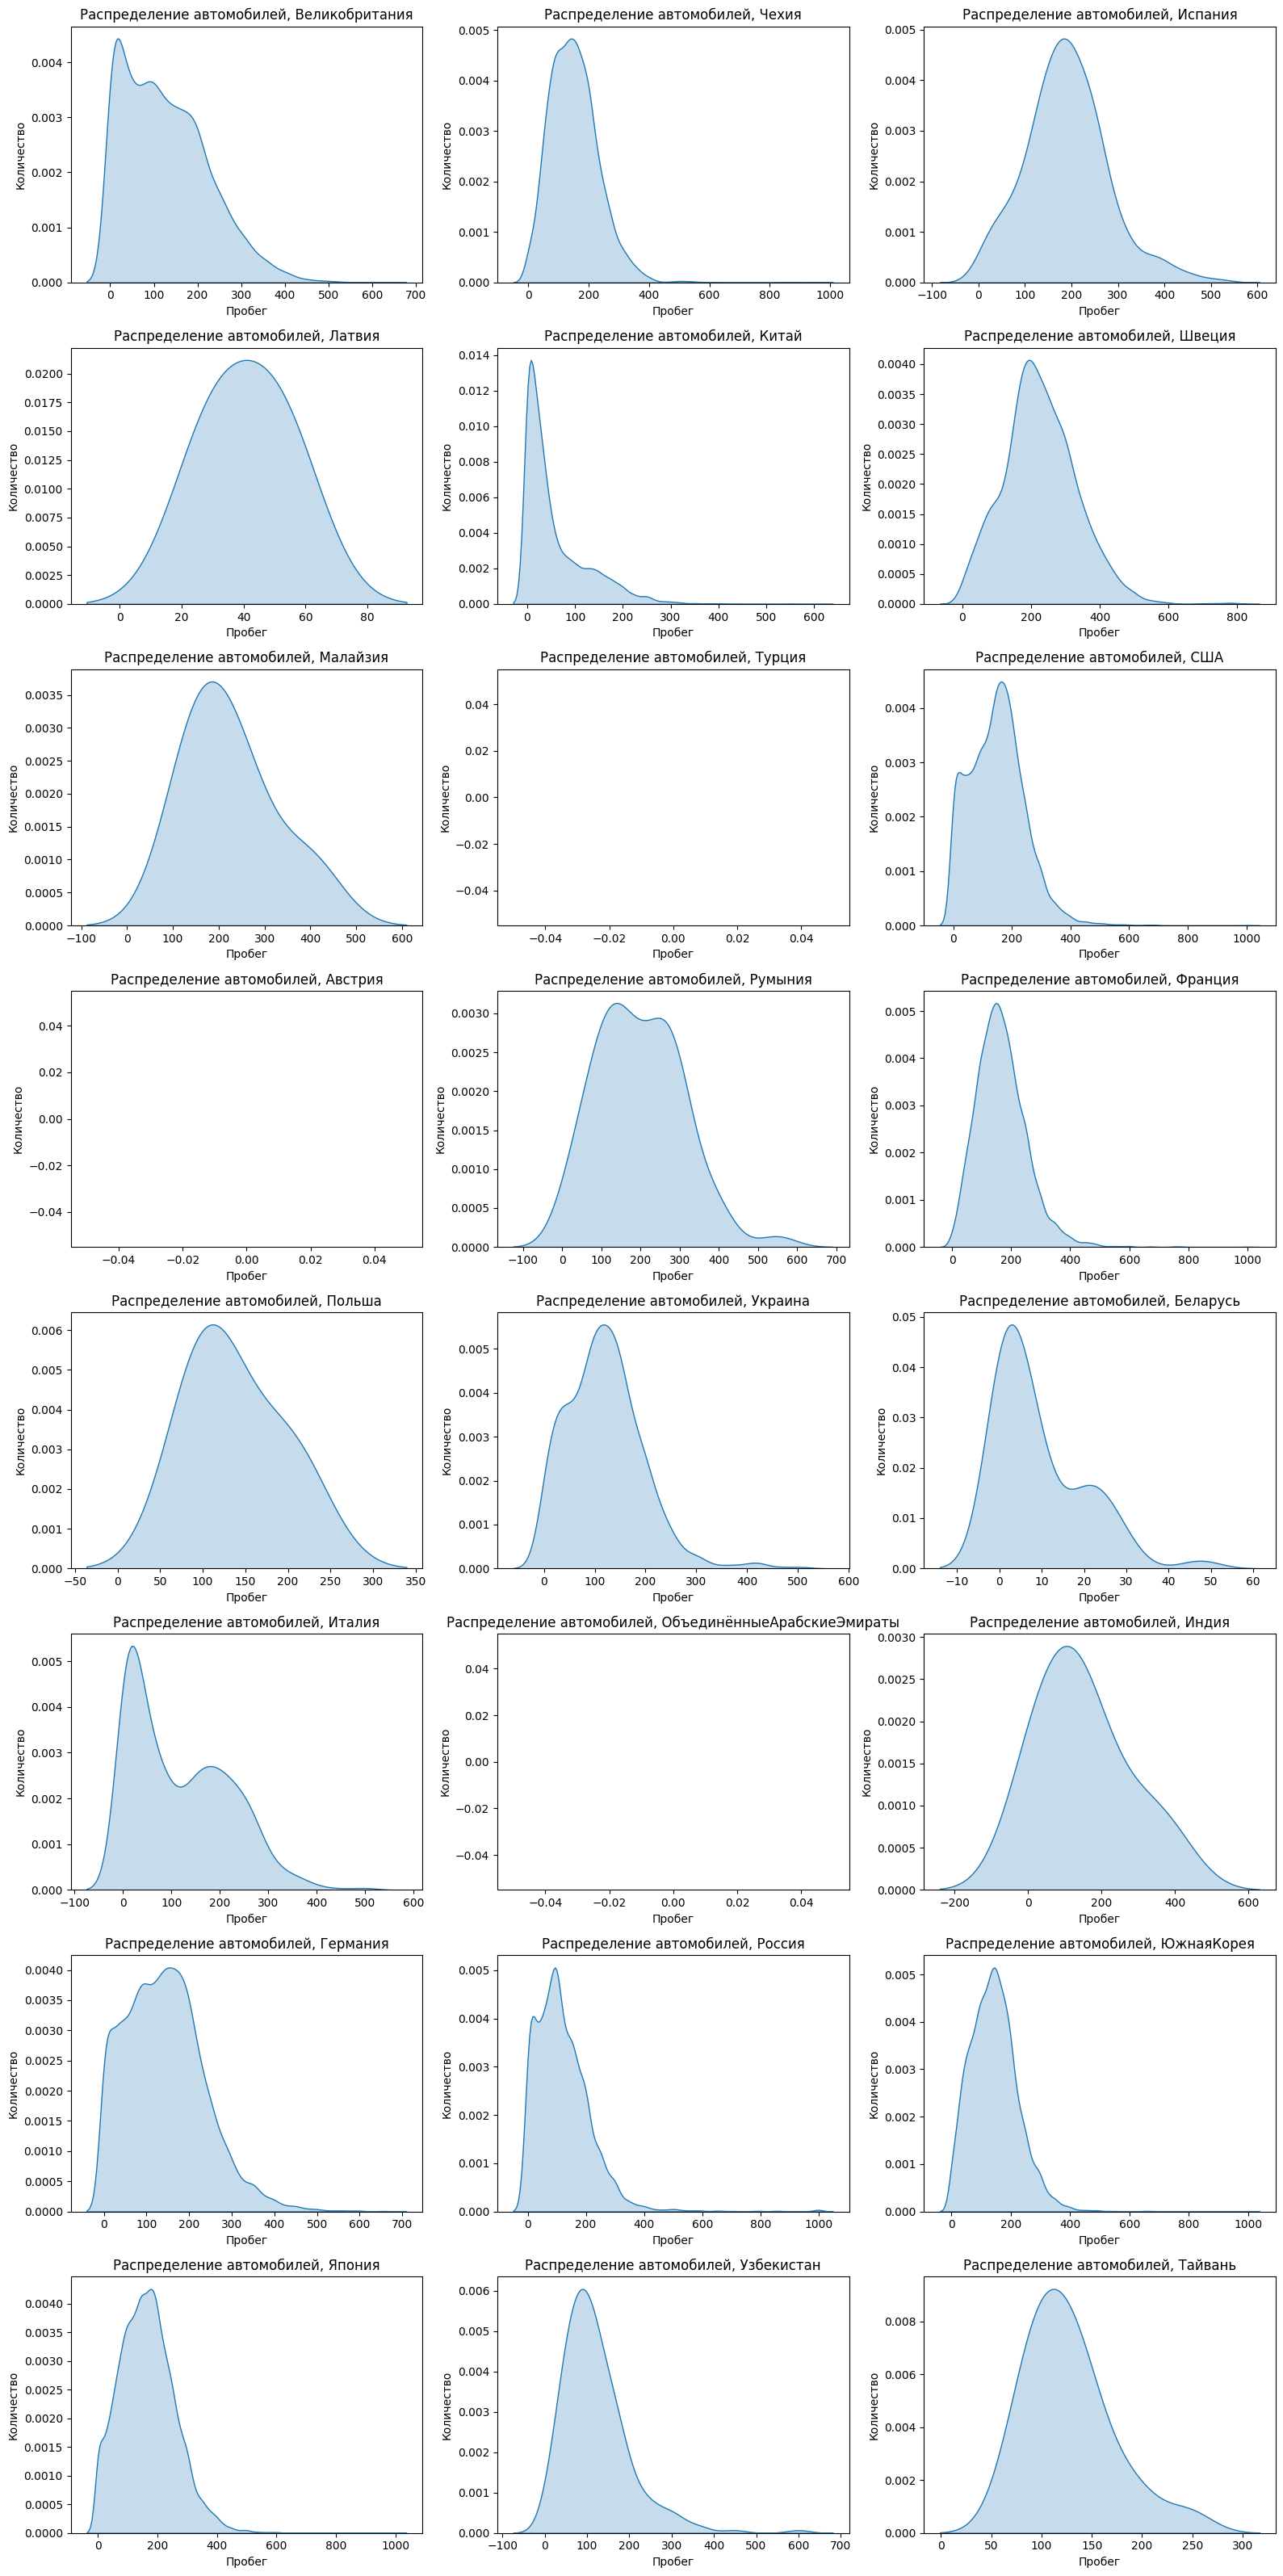

In [36]:
total_axes = len(set(df['state_mark']))
fig = plt.figure(figsize=(16, ((total_axes//3) + (total_axes % 3))*4))
for i, state in enumerate(set(df['state_mark'])):
    ax = fig.add_subplot((total_axes//3) + (total_axes % 3), 3, i+1)
    df_state = df[df['state_mark'] == state]
    sns.kdeplot(df_state['mileage'], fill=True)
    plt.title(f'Распределение автомобилей, {state}')
    plt.xlabel('Пробег')
    plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Наблюдаем сильные искажения для Китая, Беларуси - большинство подержанных автомобилей имеют малый пробег. Кроме того, автомобили из Германии и Японии имеют два пика распределения. Для построения модели скорее всего потребуется исключать автомобили с небольшим пробегом

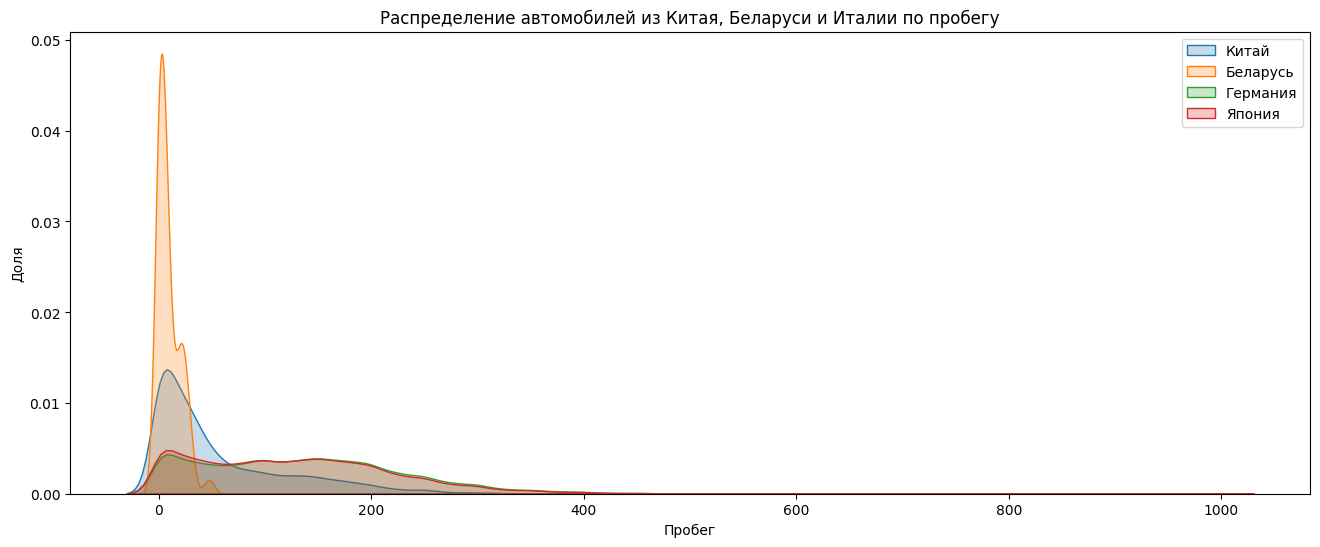

In [37]:
plt.figure(figsize= (16,6))
df_k = df[df['state_mark'] == 'Китай']
df_b = df[df['state_mark'] == 'Беларусь']
df_g = df[df['state_mark'] != 'Германия']
df_j = df[df['state_mark'] != 'Япония']
sns.kdeplot(df_k['mileage'], fill=True, label='Китай')
sns.kdeplot(df_b['mileage'], fill=True, label='Беларусь')
sns.kdeplot(df_g['mileage'], fill=True, label='Германия')
sns.kdeplot(df_j['mileage'], fill=True, label='Япония')
plt.title("Распределение автомобилей из Китая, Беларуси и Италии по пробегу")
plt.xlabel('Пробег')
plt.ylabel('Доля')
plt.legend()
plt.show()

<Axes: >

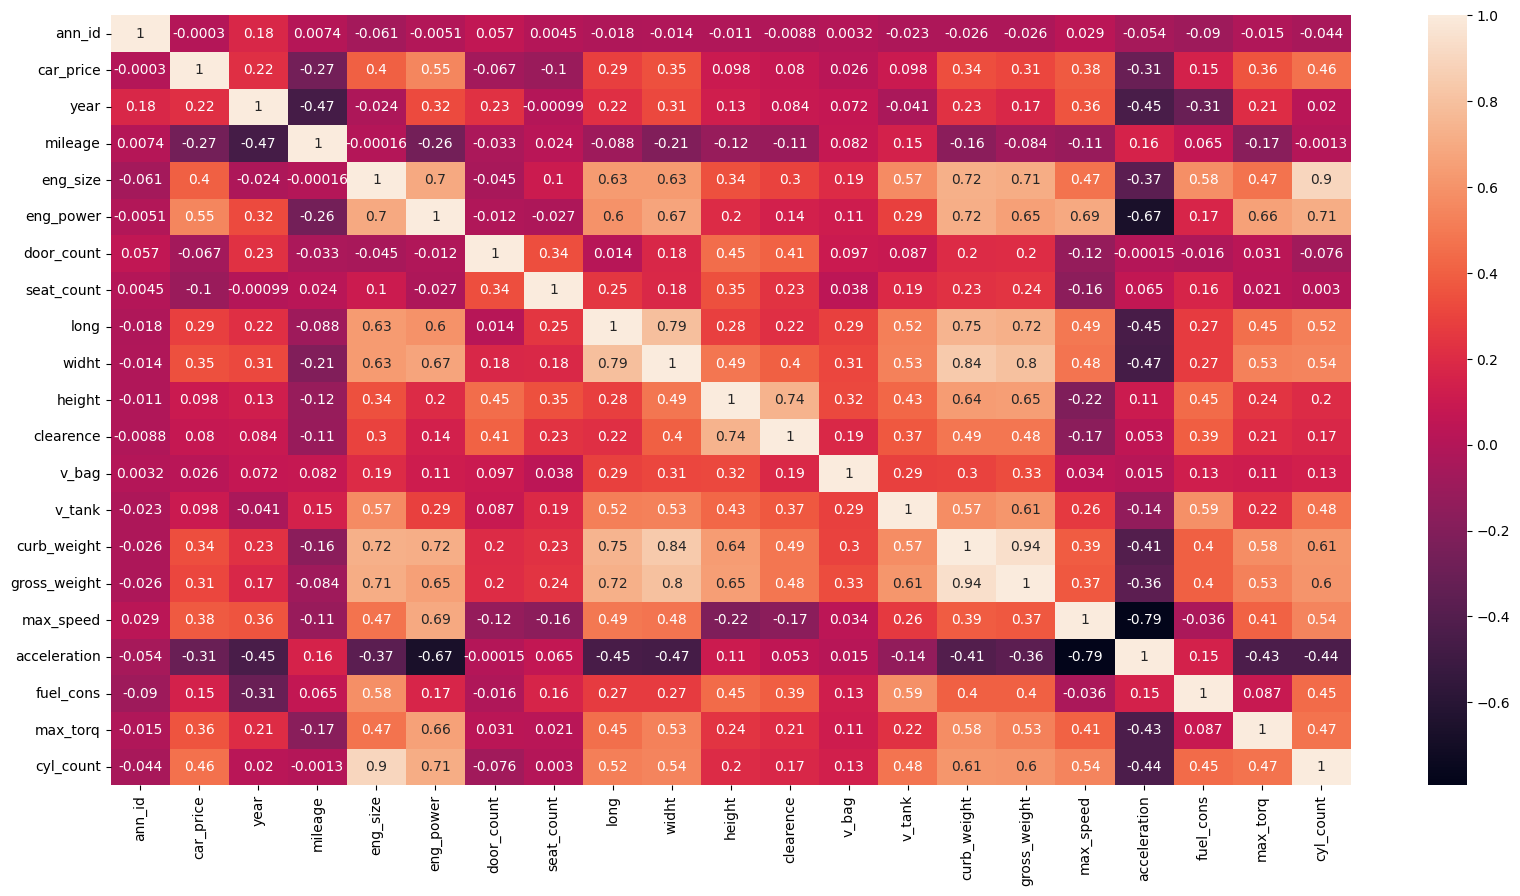

In [38]:
df_corr = df.select_dtypes(['int', 'float'])
plt.figure(figsize= (20,10))
sns.heatmap(df_corr.corr(), annot = True, fmt='.2g')

##### Из анализа нашей тепловой карты (heatmap), можно выделить следующие зависимости цены автомобиля:
1. **Сильные положительные зависимости**:
   - **"max_torq"**: Более высокий крутящий момент связан с мощностью и классом автомобиля, увеличивая его стоимость.
   - **"cyl_count"**: Больше цилиндров — сложнее двигатель, выше цена.
   - **"max_speed"**: Высокая скорость характерна для дорогих спортивных авто.

2. **Слабые или отрицательные зависимости**:
   - **"acceleration"**: Слабая корреляция с ценой, возможно, из-за нелинейных зависимостей.

3. **Взаимозависимые признаки**:
   - **"cyl_count"**, **"max_torq"**: Сильно связаны с ценой через характеристики двигателя.

4. **Потенциальные влияющие признаки**:
   - **"fuel_cons"**: Может слабо коррелировать с ценой, но важен для премиум-класса.



In [39]:

key_columns = df.select_dtypes(include=['number'])

key_columns = [col for col in key_columns if col in df.columns]

key_columns_data = df[key_columns].select_dtypes(include=["number"]) 

outs_key_summary = {}

for column in key_columns_data.columns:

    Q1 = key_columns_data[column].quantile(0.10)
    Q3 = key_columns_data[column].quantile(0.90)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    outs = key_columns_data[(key_columns_data[column] < lower_bound) | (key_columns_data[column] > upper_bound)]
    outs_count = len(outs)
    outs_key_summary[column] = {
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": outs_count,
        "Percentage Outliers": (outs_count / len(key_columns_data)) * 100,
    }

outs_key_df = pd.DataFrame(outs_key_summary).T


outs_key_df


,Lower Bound,Upper Bound,Outlier Count,Percentage Outliers
ann_id,1.116118e+09,1.131775e+09,1967.0,1.952842
car_price,-6.802169e+06,1.225695e+07,2990.0,2.968479
year,1.979500e+03,2.047500e+03,1122.0,1.113924
mileage,-3.512500e+02,6.267500e+02,70.0,0.069496
eng_size,-7.500000e-01,5.250000e+00,1993.0,1.978655
eng_power,-2.545000e+02,6.535000e+02,734.0,0.728717
door_count,2.500000e+00,6.500000e+00,2374.0,2.356912
seat_count,5.000000e+00,5.000000e+00,13408.0,13.311492
long,2.821500e+00,6.257500e+00,164.0,0.162820
widht,1.290000e+00,2.370000e+00,1.0,0.000993


In [40]:
df[df['year']<1970].head(30)

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
30375,https://auto.ru/cars/used/sale/gaz/m_20/112181...,ГАЗ,М-20«Победа»,1946-1958,Фастбек,2.1MT(52л.с.),2024-01-01,1121810909,650000,Нальчик,https://auto.ru/catalog/cars/gaz/m_20/20258133...,Вналичии,1954,300.000,коричневый,2.1,52,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/m_20/20258133...,Россия,D,5,5,4.665,1.695,1.640,20.000000,0.0,55.0,1.460000,1.835000,барабанные,барабанные,105.000000,10.072773,17.000000,gasoline,нет,127.000000,4.0
30277,https://auto.ru/cars/used/sale/gaz/69/10430439...,ГАЗ,69,1953-1972,Внедорожник5дв.69А,69А2.1MT(55л.с.)4WD,2024-01-01,1043043974,150000,Семилуки,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Вналичии,1958,30.000,зелёный,2.1,55,Бензин,3опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Россия,J,4,5,3.850,1.750,1.930,21.000000,0.0,60.0,2.066302,1.960000,барабанные,барабанные,90.000000,13.233390,17.000000,gasoline,нет,150.000000,4.0
30407,https://auto.ru/cars/used/sale/gaz/21/11177507...,ГАЗ,21«Волга»,1956-1970,Седан,21Л2.5MT(75л.с.),2024-01-02,1117750723,2500000,Краснодар,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Вналичии,1962,0.500,серый,2.5,75,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Россия,D,4,5,4.770,1.885,1.620,19.000000,400.0,60.0,1.460000,1.885000,барабанные,барабанные,130.000000,25.000000,11.000000,gasoline,нет,170.000000,4.0
29255,https://auto.ru/cars/used/sale/gaz/69/11064752...,ГАЗ,69,1953-1972,Внедорожник3дв.,2.1MT(55л.с.)4WD,2024-01-03,1106475252,650000,Рязань,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Вналичии,1964,20.000,зелёный,2.1,55,Бензин,18опций,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/69/20351692/2...,Россия,J,2,7,3.850,1.750,1.930,21.000000,0.0,75.0,2.066302,2.175000,барабанные,барабанные,90.000000,13.233390,17.000000,gasoline,нет,150.000000,4.0
29522,https://auto.ru/cars/used/sale/gaz/21/10281185...,ГАЗ,21«Волга»,1956-1970,Седан,21Р2.5MT(75л.с.),2024-01-03,1028118509,500000,Санкт-Петербург,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Вналичии,1967,150.000,синий,2.5,75,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Россия,D,4,5,4.770,1.885,1.620,19.000000,400.0,60.0,1.460000,1.885000,барабанные,барабанные,130.000000,25.000000,11.000000,gasoline,нет,170.000000,4.0
57160,https://auto.ru/cars/used/sale/moscvich/400/11...,Москвич,400,1946-1956,Кабриолет,400-4201.1MT(23л.с.),2024-01-03,1121820769,1650000,Санкт-Петербург,https://auto.ru/catalog/cars/moscvich/400/2035...,Вналичии,1950,0.500,красный,1.1,23,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/400/2035...,Россия,C,4,4,3.855,1.400,1.555,20.000000,0.0,31.0,0.885000,1.155000,барабанные,барабанные,90.000000,11.022000,5.112871,gasoline,нет,55.000000,4.0
30447,https://auto.ru/cars/used/sale/gaz/21/11020907...,ГАЗ,21«Волга»,1956-1970,Седан,21Р2.5MT(75л.с.),2024-01-05,1102090761,500000,Ейск,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Вналичии,1967,65.000,голубой,2.5,75,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/21/7867811/78...,Россия,D,4,5,4.770,1.885,1.620,19.000000,400.0,60.0,1.460000,1.885000,барабан

In [41]:
output_file_path = 'data.csv'
combined_df.to_csv(output_file_path, index=False)

NameError: name 'combined_df' is not defined


Для прогнозирования цены автомобиля нужно отобрать признаки с сильной корреляцией с ценой (например, мощность двигателя, количество цилиндров), исключить избыточные признаки (мультиколлинеарность) и обработать категориальные данные. Важно устранить выбросы, масштабировать числовые признаки и протестировать разные модели: от простых (линейная регрессия, дерево решений) до сложных (Random Forest, XGBoost). Методы нелинейного моделирования предпочтительны из-за сложных зависимостей. Для оценки качества модели использовать метрики RMSE, MAE, R² и перекрёстную валидацию. Так как правильная подготовка данных и выбор моделей обеспечат точное прогнозирование.

In [41]:
# numeric_columns = df.select_dtypes(include=['number'])

# Q1 = numeric_columns.quantile(0.10)
# Q3 = numeric_columns.quantile(0.90)
# IQR = Q3 - Q1

# lower_bound = Q1 - 3.5 * IQR
# upper_bound = Q3 + 3.5 * IQR

# df = df[~((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)]

# print(df.describe(), df.info())

Столбец: url_car
Уникальные значения:
['https://auto.ru/cars/used/sale/abarth/500/1118403975-c034a445/'
 'https://auto.ru/cars/used/sale/abarth/500/1124579446-7c107d23/'
 'https://auto.ru/cars/used/sale/abarth/500/1124960149-eca1fc82/' ...
 'https://auto.ru/cars/used/sale/zx/landmark/1124044683-deb2fb12/'
 'https://auto.ru/cars/used/sale/zx/landmark/1125875416-aa368924/'
 'https://auto.ru/cars/used/sale/zx/landmark/1126054523-cce1e719/']

Столбец: car_make
Уникальные значения:
['AC' 'Abarth' 'Acura' 'Adler' 'Aito' 'Aixam' 'AlfaRomeo' 'Alpina'
 'Alpine' 'Ambertruck' 'Arcfox' 'Ariel' 'Aro' 'Asia' 'AstonMartin' 'Audi'
 'Aurus' 'Austin' 'Avatr' 'BAIC' 'BAW' 'BMW' 'BYD' 'Bajaj' 'BaltijasDzips'
 'Baojun' 'Belgee' 'Bentley' 'Brilliance' 'Bugatti' 'Buick' 'CHERY'
 'Cadillac' 'Changan' 'Changfeng' 'Chevrolet' 'Chrysler'
 'Ciimo(Dongfeng-Honda)' 'Citroen' 'Coda' 'Cupra' 'DS' 'DWHower' 'Dacia'
 'Dadi' 'Daewoo' 'Daihatsu' 'Daimler' 'Datsun' 'Dayun' 'Delage' 'Denza'
 'Derways' 'Dodge' 'Dongfeng' 'D

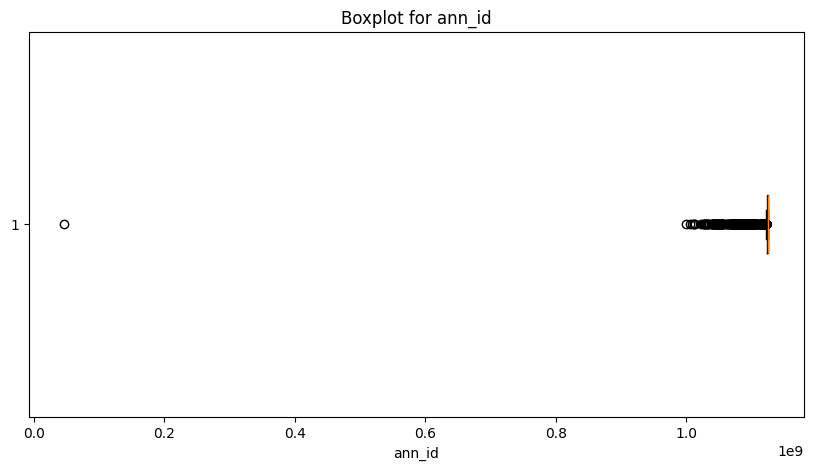

Столбец: car_price
Уникальные значения:
[    10500     16000     25000 ... 500370240 516000000 550000000]



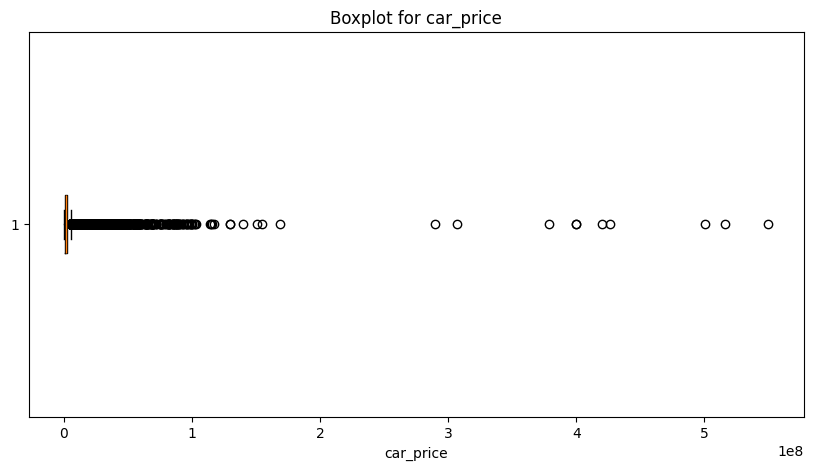

Столбец: ann_city
Уникальные значения:
['Абакан' 'Абан' 'Абатское' ... 'районКоммунарка' 'районЩербинка'
 'селоВад']

Столбец: link_cpl
Уникальные значения:
['https://auto.ru/catalog/cars/abarth/500/24005520/24005524/specifications/24005524__20464026/'
 'https://auto.ru/catalog/cars/abarth/500/24005520/24005531/specifications/24005531__6422768/'
 'https://auto.ru/catalog/cars/abarth/500/24005654/24005682/specifications/24005682__21199022/'
 ...
 'https://auto.ru/catalog/cars/zx/landmark/20351565/20475231/specifications/20475231__20475298/'
 'https://auto.ru/catalog/cars/zx/landmark/20351565/20475231/specifications/20475231__20475309/'
 'https://auto.ru/catalog/cars/zx/landmark/20351569/20475361/specifications/20475361__20475401/']

Столбец: avail
Уникальные значения:
['Вналичии' 'Впути' 'Назаказ']

Столбец: year
Уникальные значения:
[1923 1932 1935 1936 1937 1938 1939 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 19

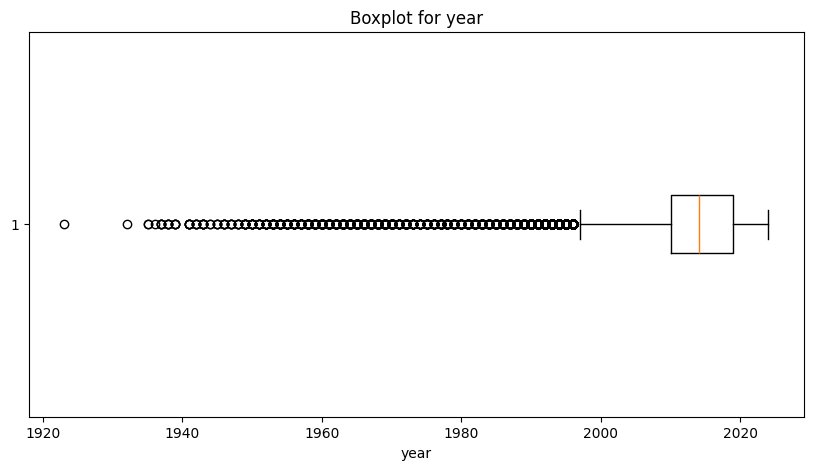

Столбец: mileage
Уникальные значения:
[1.00000e-03 2.00000e-03 3.00000e-03 ... 9.99985e+02 9.99999e+02
 1.00000e+03]



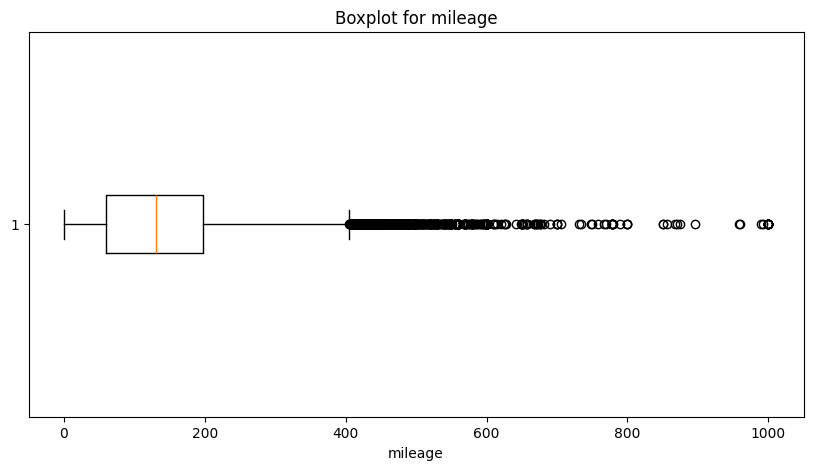

Столбец: color
Уникальные значения:
['бежевый' 'белый' 'голубой' 'жёлтый' 'зелёный' 'золотистый' 'коричневый'
 'красный' 'оранжевый' 'пурпурный' 'розовый' 'серебристый' 'серый' 'синий'
 'фиолетовый' 'чёрный']

Столбец: eng_size
Уникальные значения:
[0.2        0.4        0.5        0.6        0.7        0.8
 0.89314308 0.9        1.         1.1        1.2        1.3
 1.4        1.5        1.5455426  1.6        1.7        1.72633423
 1.76239316 1.8        1.85015233 1.9        2.         2.1
 2.13309572 2.2        2.3        2.4        2.5        2.6
 2.7        2.8        2.83301404 2.9        2.98583536 3.
 3.1        3.2        3.3        3.4        3.5        3.6
 3.66897436 3.7        3.8        3.9        4.         4.03962571
 4.1        4.2        4.3        4.4        4.5        4.6
 4.7        4.8        4.9        5.         5.2        5.3
 5.4        5.5        5.6        5.7        5.8        5.9
 6.         6.1        6.2        6.3        6.4        6.5
 6.6        6.7   

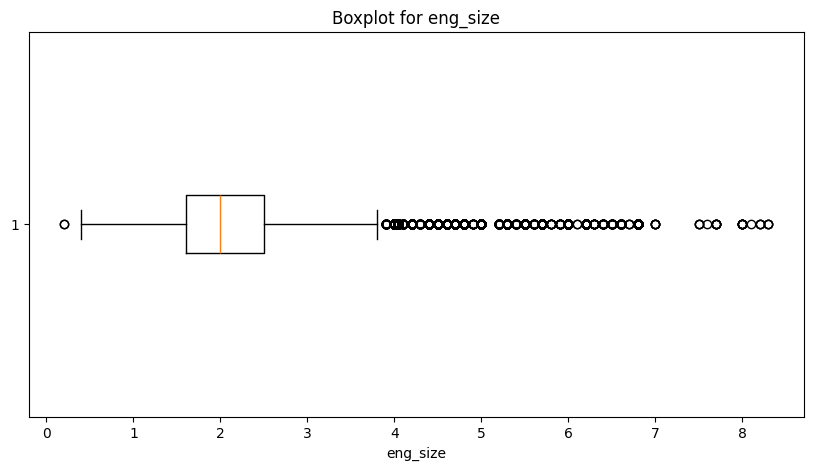

Столбец: eng_power
Уникальные значения:
[  10   12   13   23   25   26   27   30   33   35   38   39   40   41
   42   44   45   46   48   49   50   52   53   54   55   56   58   59
   60   61   62   63   64   65   66   67   68   69   70   71   72   73
   74   75   76   77   78   79   80   81   82   83   84   85   86   87
   88   89   90   91   92   93   94   95   96   97   98   99  100  101
  102  103  104  105  106  107  108  109  110  111  112  113  114  115
  116  117  118  119  120  121  122  123  124  125  126  127  128  129
  130  131  132  133  134  135  136  137  138  139  140  141  142  143
  144  145  146  147  148  149  150  151  152  153  154  155  156  157
  158  159  160  161  162  163  164  165  166  167  168  169  170  171
  172  173  174  175  176  177  178  179  180  181  182  183  184  185
  186  187  188  189  190  191  192  193  194  195  196  197  198  199
  200  201  202  203  204  205  206  207  208  209  210  211  212  213
  214  215  216  217  218  219  220  

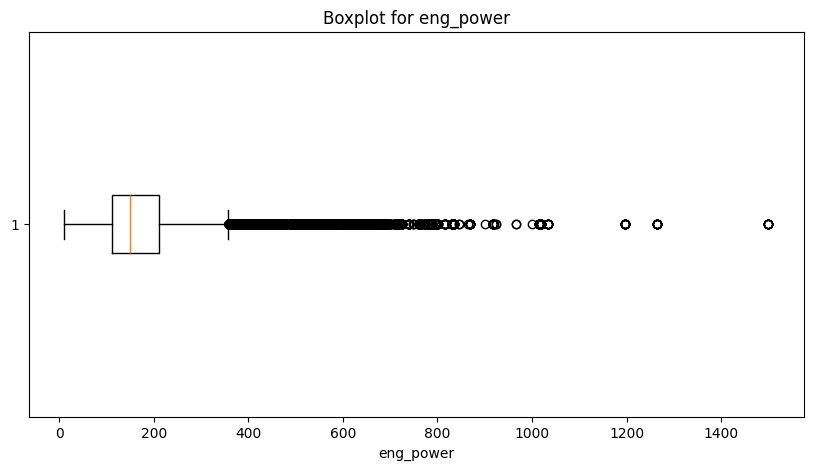

Столбец: eng_type
Уникальные значения:
['Бензин' 'Газ' 'Гибрид' 'Гибрид.газобаллонноеоборудование' 'Дизель'
 'Электро']

Столбец: options
Уникальные значения:
['"#CLUB24"' '"Classic22"' '"Classic22Advance"' ... 'ЭлегансПлюс'
 'ЮбилейнаясерияAnniversary20' 'Юбилейный']

Столбец: transmission
Уникальные значения:
['автоматическая' 'вариатор' 'механическая' 'роботизированная']

Столбец: drive
Уникальные значения:
['задний' 'передний' 'полный']

Столбец: st_wheel
Уникальные значения:
['Левый' 'Правый']

Столбец: condition
Уникальные значения:
['Нетребуетремонта']

Столбец: count_owner
Уникальные значения:
['1владелец' '2владельца' '3илиболее']

Столбец: original_pts
Уникальные значения:
['Дубликат' 'Оригинал']

Столбец: customs
Уникальные значения:
['Растаможен' 'Растаможен.нет\\xa0ПТС']

Столбец: url_compl
Уникальные значения:
['https://auto.ru/catalog/cars/abarth/500/24005520/24005524/specifications/24005524__20464026/'
 'https://auto.ru/catalog/cars/abarth/500/24005520/24005531/specific

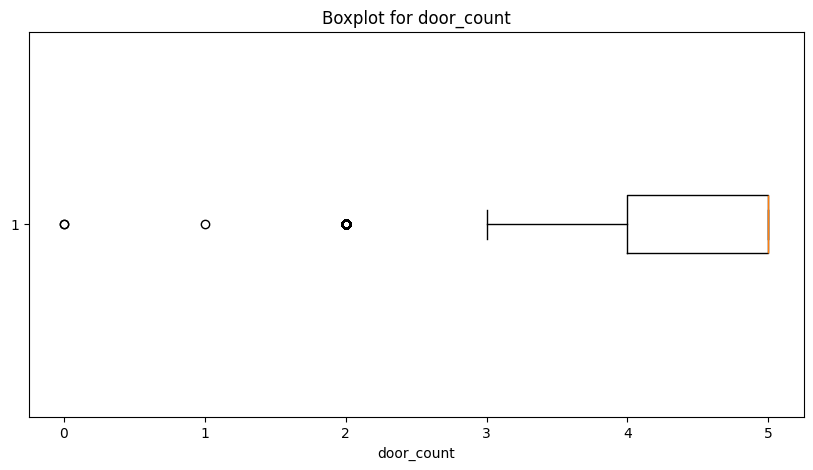

Столбец: seat_count
Уникальные значения:
[2 3 4 5 6 7 8 9]



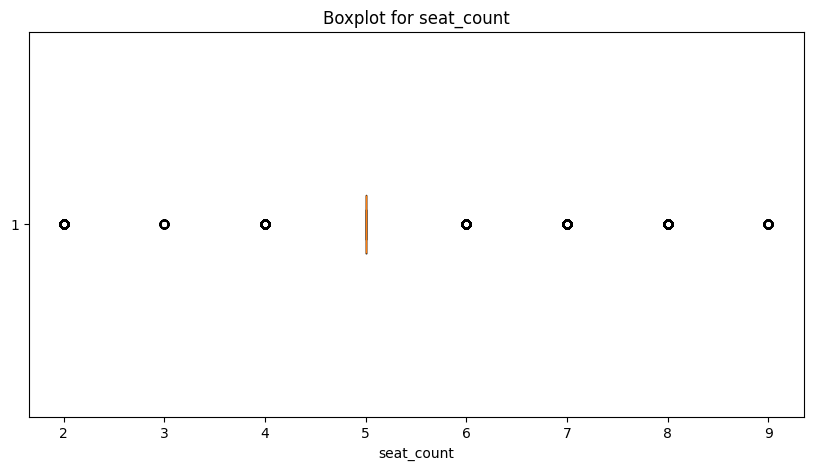

Столбец: long
Уникальные значения:
[2.488 2.499 2.5   ... 6.297 6.305 6.33 ]



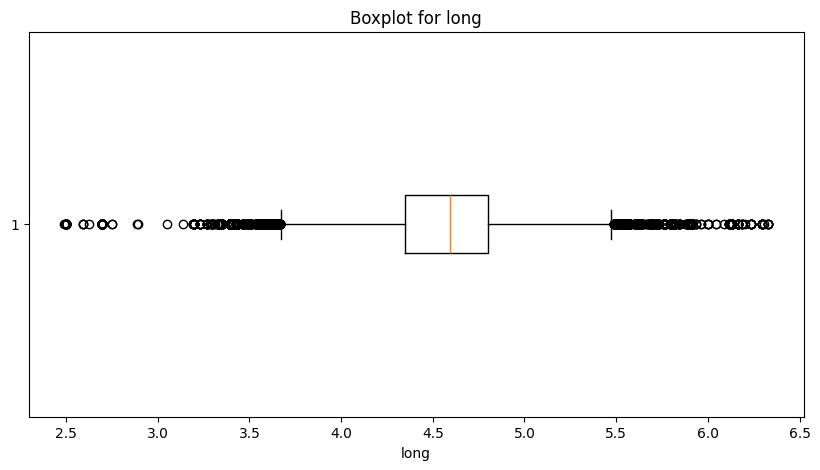

Столбец: widht
Уникальные значения:
[1.    1.312 1.316 1.372 1.38  1.382 1.395 1.4   1.41  1.415 1.42  1.43
 1.44  1.468 1.47  1.473 1.475 1.48  1.495 1.5   1.506 1.508 1.51  1.515
 1.519 1.524 1.53  1.535 1.537 1.54  1.545 1.547 1.55  1.554 1.555 1.559
 1.56  1.563 1.575 1.578 1.579 1.58  1.585 1.589 1.59  1.594 1.595 1.597
 1.6   1.605 1.608 1.61  1.611 1.613 1.614 1.615 1.618 1.62  1.621 1.622
 1.625 1.626 1.627 1.628 1.63  1.631 1.634 1.635 1.636 1.639 1.64  1.641
 1.642 1.643 1.644 1.645 1.646 1.648 1.65  1.651 1.652 1.654 1.655 1.658
 1.659 1.66  1.661 1.662 1.663 1.664 1.665 1.666 1.667 1.669 1.67  1.671
 1.672 1.673 1.675 1.676 1.678 1.679 1.68  1.682 1.683 1.684 1.685 1.686
 1.687 1.688 1.689 1.69  1.692 1.693 1.694 1.695 1.696 1.698 1.699 1.7
 1.702 1.703 1.704 1.705 1.706 1.707 1.708 1.709 1.71  1.711 1.712 1.713
 1.714 1.715 1.716 1.717 1.718 1.719 1.72  1.722 1.724 1.725 1.727 1.728
 1.729 1.73  1.731 1.732 1.733 1.735 1.736 1.737 1.738 1.739 1.74  1.741
 1.742 1.743 1.744

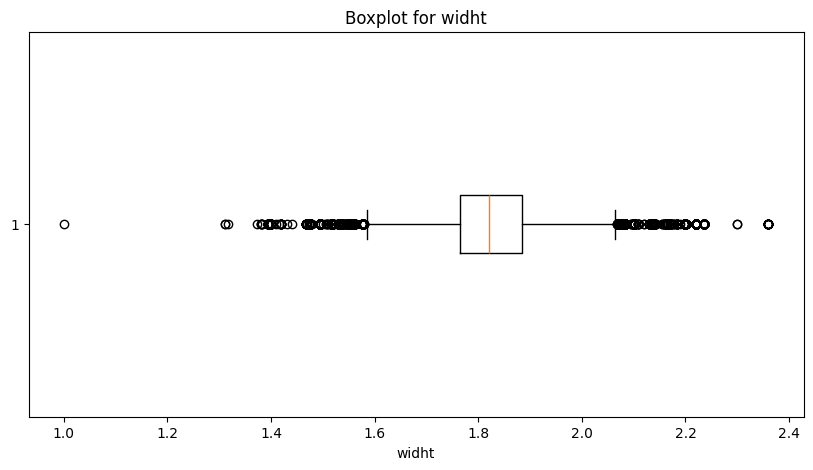

Столбец: height
Уникальные значения:
[1.    1.07  1.105 1.12  1.129 1.13  1.135 1.136 1.139 1.14  1.15  1.155
 1.16  1.165 1.166 1.169 1.17  1.18  1.183 1.186 1.187 1.188 1.191 1.192
 1.193 1.194 1.195 1.196 1.2   1.201 1.202 1.206 1.209 1.21  1.211 1.212
 1.213 1.214 1.219 1.22  1.224 1.23  1.232 1.233 1.234 1.235 1.236 1.239
 1.24  1.242 1.245 1.246 1.247 1.248 1.25  1.252 1.255 1.258 1.26  1.261
 1.262 1.265 1.267 1.269 1.27  1.273 1.275 1.276 1.278 1.279 1.28  1.281
 1.282 1.285 1.287 1.288 1.29  1.291 1.292 1.293 1.294 1.295 1.296 1.297
 1.298 1.299 1.3   1.301 1.302 1.303 1.304 1.305 1.306 1.308 1.31  1.315
 1.317 1.318 1.32  1.321 1.322 1.323 1.326 1.329 1.33  1.334 1.336 1.338
 1.34  1.341 1.342 1.343 1.344 1.345 1.346 1.348 1.349 1.35  1.351 1.352
 1.353 1.354 1.355 1.358 1.359 1.36  1.362 1.364 1.365 1.366 1.367 1.368
 1.369 1.37  1.371 1.372 1.373 1.374 1.375 1.376 1.377 1.378 1.379 1.38
 1.381 1.382 1.383 1.384 1.385 1.386 1.387 1.388 1.389 1.39  1.391 1.392
 1.393 1.394 1.

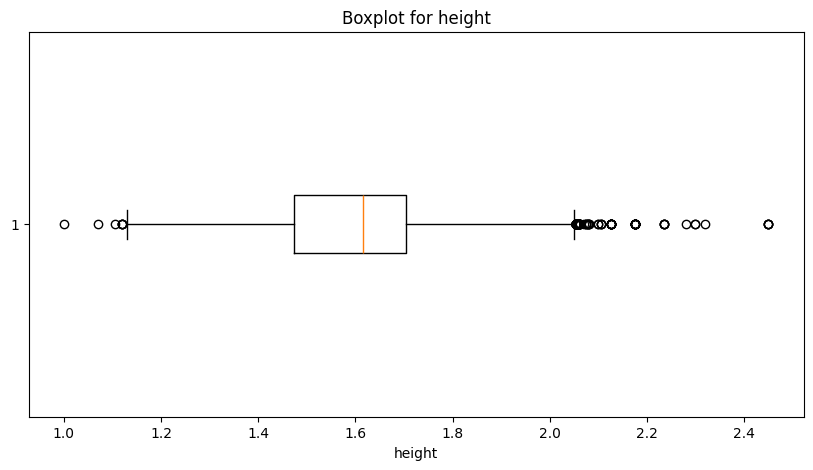

Столбец: clearence
Уникальные значения:
[ 7.6         8.          8.6         8.8         8.9         9.
  9.1         9.3         9.4         9.5         9.7         9.8
  9.9        10.         10.2        10.3        10.4        10.5
 10.6        10.7        10.8        10.9        11.         11.2
 11.3        11.4        11.5        11.6        11.7        11.8
 11.9        12.         12.09796108 12.1        12.2        12.3
 12.4        12.5        12.6        12.7        12.8        12.9
 13.         13.1        13.2        13.3        13.4        13.5
 13.6        13.7        13.8        13.9        14.         14.1
 14.2        14.3        14.4        14.5        14.6        14.7
 14.8        14.9        14.9886785  15.         15.1        15.2
 15.3        15.4        15.47822441 15.5        15.6        15.6556231
 15.7        15.8        15.9        16.         16.1        16.2
 16.3        16.4        16.5        16.51023346 16.6        16.7
 16.8        16.9        16.932

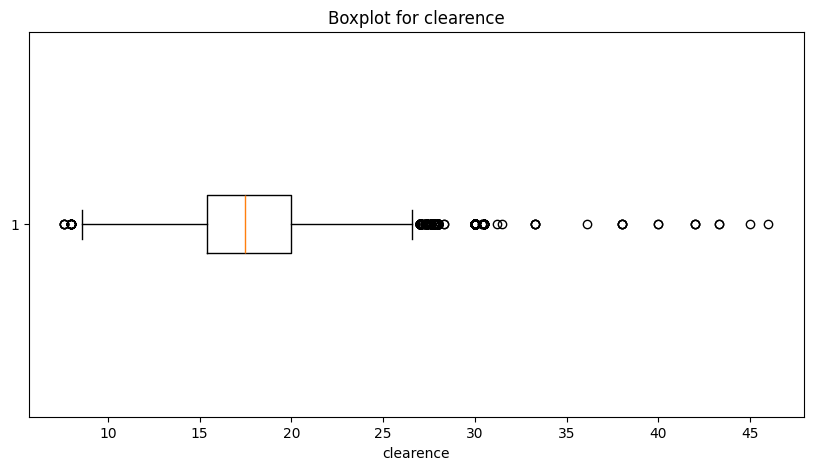

Столбец: v_bag
Уникальные значения:
[   0.   50.   53.   57.   60.   63.   65.   74.   76.   80.   81.   83.
   84.   85.   90.   96.   98.  100.  104.  105.  108.  110.  112.  113.
  115.  120.  123.  125.  128.  129.  130.  131.  132.  135.  137.  139.
  140.  142.  145.  147.  150.  152.  154.  155.  157.  158.  159.  160.
  164.  165.  166.  168.  169.  170.  175.  176.  178.  180.  181.  184.
  185.  186.  187.  188.  190.  193.  196.  197.  200.  201.  202.  204.
  205.  206.  207.  208.  209.  210.  211.  213.  214.  215.  216.  220.
  222.  224.  225.  226.  227.  228.  230.  232.  233.  234.  235.  236.
  240.  241.  243.  244.  245.  246.  248.  249.  250.  251.  253.  255.
  256.  257.  258.  259.  260.  262.  264.  265.  266.  267.  268.  269.
  270.  272.  275.  276.  277.  278.  280.  281.  282.  284.  285.  286.
  287.  288.  289.  290.  291.  292.  293.  295.  296.  297.  298.  299.
  300.  301.  302.  303.  304.  305.  306.  307.  308.  309.  310.  311.
  312.  313.  3

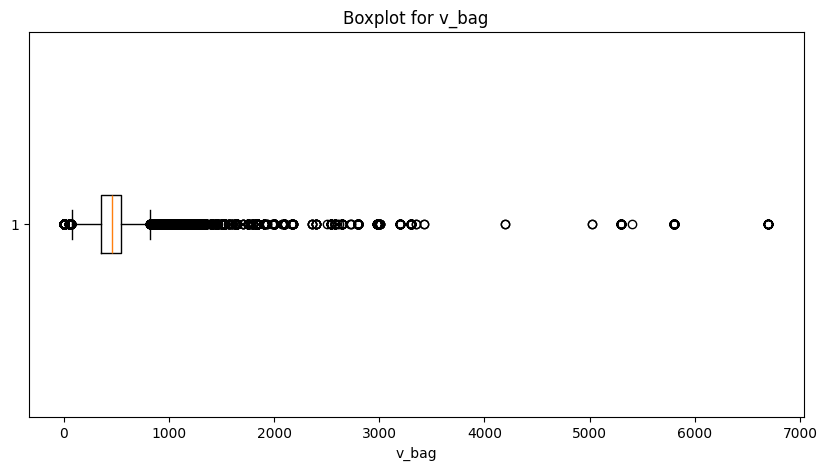

Столбец: v_tank
Уникальные значения:
[  0.  16.  20.  22.  24.  26.  27.  28.  30.  31.  32.  33.  34.  35.
  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98. 100. 102. 104. 105. 106. 107. 108.
 109. 110. 113. 114. 115. 117. 119. 120. 121. 122. 123. 125. 127. 129.
 130. 132. 136. 140. 159. 166.]



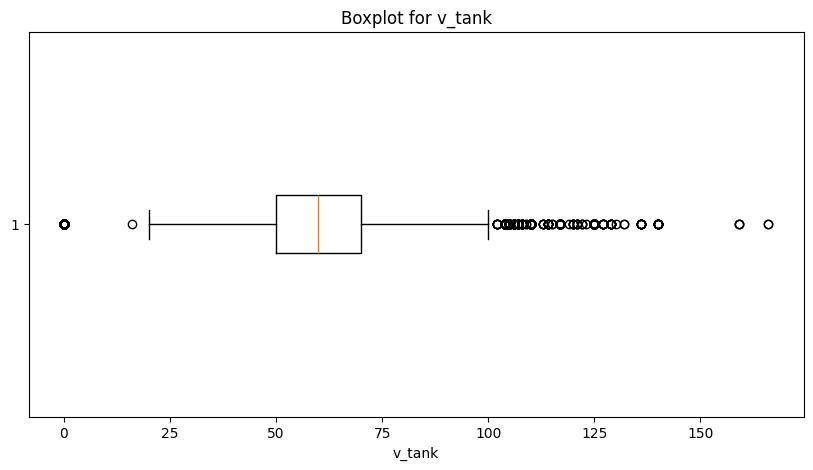

Столбец: curb_weight
Уникальные значения:
[0.399 0.425 0.454 ... 3.85  3.95  4.103]



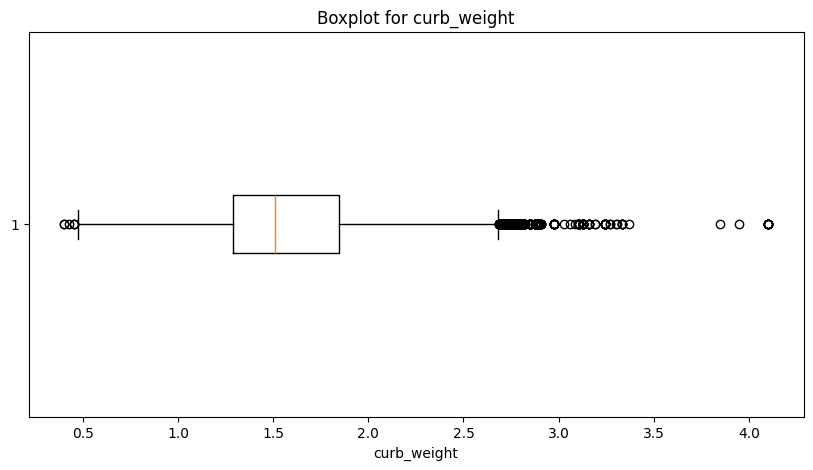

Столбец: gross_weight
Уникальные значения:
[0.81       0.895      0.92       0.94       0.95       0.96
 0.975      0.98       0.985      0.99       1.         1.01
 1.015      1.02       1.03       1.04       1.05       1.06
 1.07       1.08       1.085      1.09       1.095      1.1
 1.115      1.12       1.127      1.14       1.145      1.15
 1.155      1.16       1.165      1.18       1.185      1.19
 1.191      1.195      1.2        1.21       1.215      1.22
 1.22423248 1.23       1.235      1.245      1.25       1.255
 1.26       1.265      1.27       1.275      1.28       1.286
 1.287      1.29       1.295      1.3        1.305      1.306
 1.31       1.315      1.32       1.325      1.33       1.335
 1.34       1.345      1.35       1.355      1.356      1.36
 1.362      1.363      1.365      1.367      1.37       1.375
 1.377      1.38       1.385      1.39       1.395      1.4
 1.404      1.405      1.41       1.415      1.42       1.425
 1.43       1.435      1.44       1.44

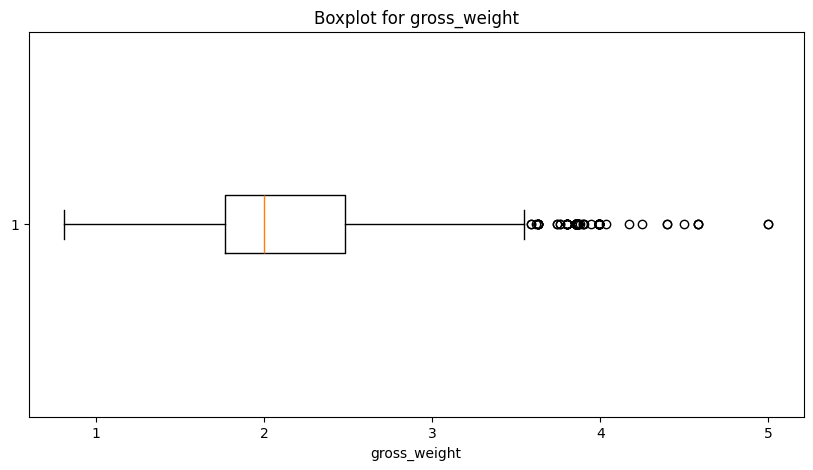

Столбец: front_brakes
Уникальные значения:
['барабанные' 'дисковые' 'керамические']

Столбец: rear_brakes
Уникальные значения:
['барабанные' 'дисковые' 'керамические']

Столбец: max_speed
Уникальные значения:
[ 60.          70.          75.          85.          87.
  88.          90.          95.         100.         101.
 102.         104.         105.         107.         110.
 115.         117.         118.         120.         125.
 126.         128.         129.         130.         132.
 133.         134.         135.         137.         138.
 139.         140.         141.         142.         143.
 144.         145.         146.         146.51277454 147.
 148.         149.         150.         151.         152.
 153.         154.         155.         156.         157.
 157.86567164 158.         159.         160.         161.
 162.         163.         164.         165.         166.
 167.         168.         169.         170.         170.32036424
 171.         172.         17

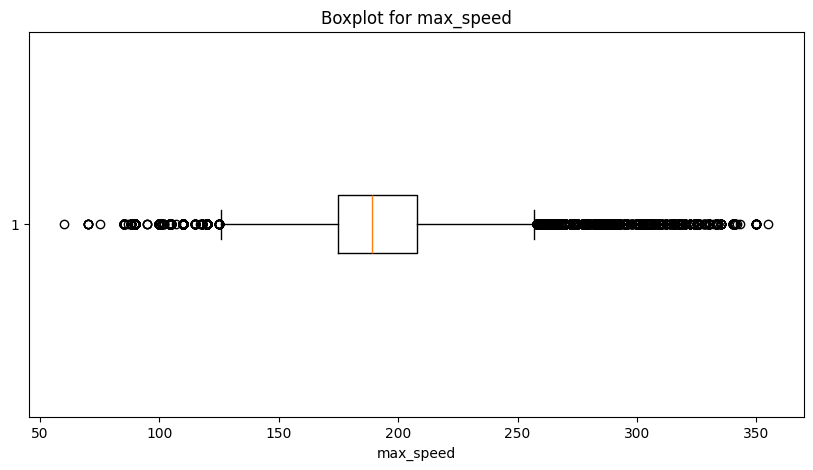

Столбец: acceleration
Уникальные значения:
[ 2.02        2.1         2.3         2.5         2.6         2.7
  2.78        2.8         2.84        2.85        2.9         2.95
  3.          3.1         3.2         3.3         3.4         3.45
  3.49        3.5         3.6         3.7         3.8         3.9
  3.96        3.98        4.          4.1         4.15        4.2
  4.3         4.4         4.5         4.6         4.7         4.7673263
  4.8         4.9         5.          5.1         5.15        5.2
  5.3         5.4         5.5         5.6         5.7         5.8
  5.9         5.95        5.97        6.          6.1         6.2
  6.2198627   6.3         6.31        6.4         6.5         6.6
  6.7         6.76        6.8         6.9         6.95        7.
  7.1         7.2         7.29        7.3         7.4         7.41023029
  7.47        7.5         7.6         7.68        7.7         7.8
  7.9         8.          8.1         8.2         8.3         8.4
  8.5         8.6  

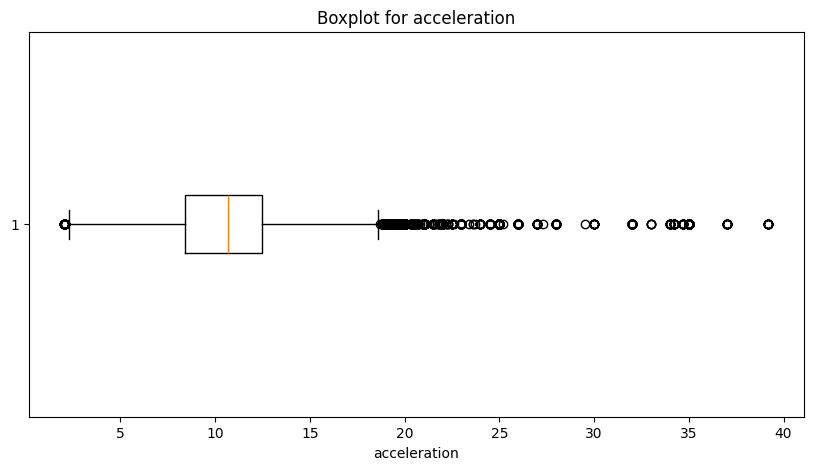

Столбец: fuel_cons
Уникальные значения:
[ 0.          1.4         1.5         1.6         2.7         2.9
  3.          3.1         3.2         3.3         3.4         3.5
  3.6         3.7         3.8         3.9         4.          4.0125
  4.0825      4.1         4.2         4.24061303  4.28571429  4.3
  4.4         4.45555556  4.5         4.55        4.6         4.7
  4.71557692  4.8         4.9         4.93333333  4.99483283  5.
  5.1         5.11287129  5.2         5.23048561  5.3         5.31666667
  5.33259595  5.34038462  5.4         5.41558937  5.47207792  5.5
  5.525       5.54592593  5.6         5.60894134  5.62815612  5.66666667
  5.7         5.74883311  5.75800604  5.8         5.83040541  5.875
  5.9         6.          6.1         6.13819055  6.14388291  6.14645208
  6.16490987  6.2         6.23        6.3         6.30378378  6.33709677
  6.38541667  6.4         6.46448598  6.5         6.50393591  6.59390119
  6.6         6.67822054  6.7         6.8         6.82971429  6

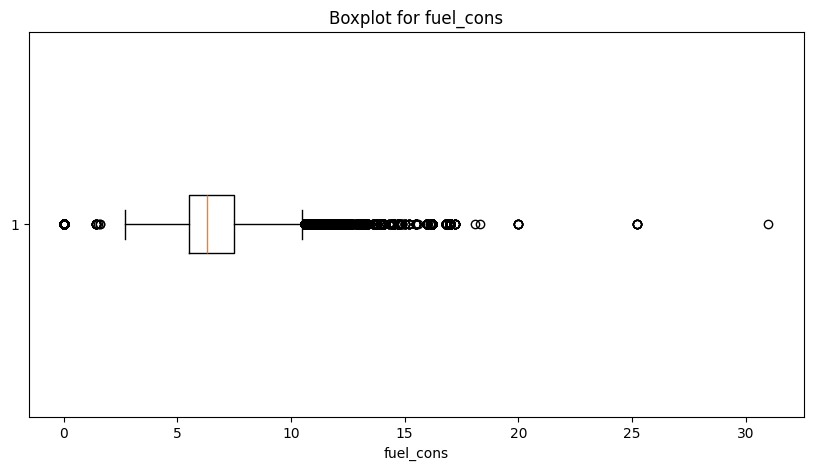

Столбец: fuel_brand
Уникальные значения:
['Electro' 'diesel' 'gas' 'gasoline' 'unknown']

Столбец: turbocharg
Уникальные значения:
['компрессор' 'нет' 'турбонаддув']

Столбец: max_torq
Уникальные значения:
[   19.            29.            42.            45.
    52.            53.            55.            56.
    57.            58.            59.            60.
    61.            62.            63.            64.
    65.            67.            69.            70.
    72.            73.            74.            75.
    76.            78.            79.            80.
    81.            82.            82.78945266    83.
    84.            85.            86.            87.
    88.            89.            90.            91.
    92.            93.            94.            95.
    96.            97.            98.            99.
   100.           101.           102.           103.
   104.           105.           106.           107.
   108.           109.           110.           111.

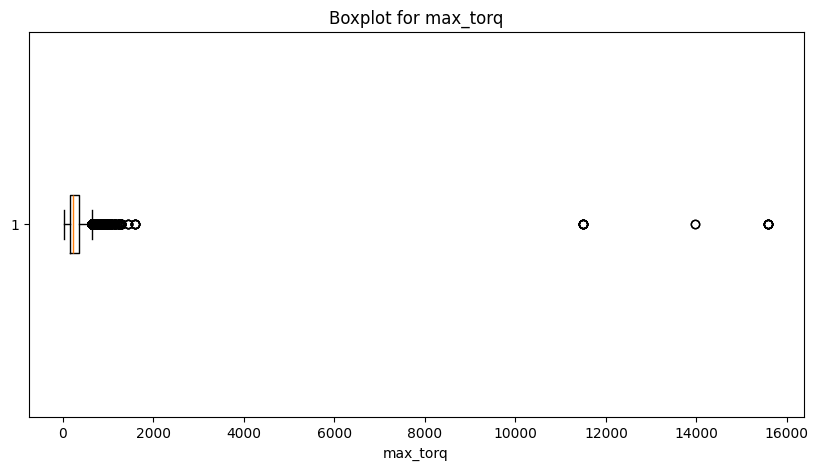

Столбец: cyl_count
Уникальные значения:
[ 1.          2.          3.          3.21442727  3.92111132  3.99892761
  4.          4.07335364  4.15384615  4.22550916  5.          5.18009888
  5.38988554  6.          6.82051282  7.38974776  8.         10.
 12.         16.        ]



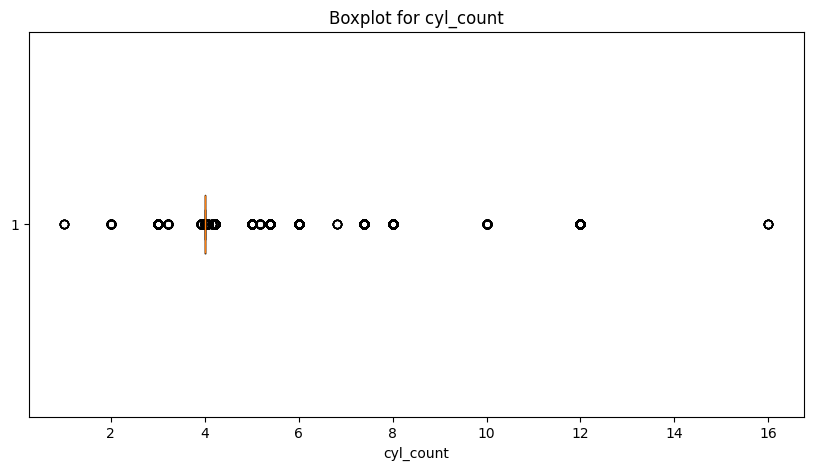

In [42]:
def analyze_columns(data, columns):
    for col in columns:
        print(f"Столбец: {col}")
        print("Уникальные значения:")
        print(data[col].sort_values().unique())
        print()

        if data[col].dtype in ['int64', 'float64']:
            plt.figure(figsize=(10, 5))
            plt.boxplot(data[col].dropna(), vert=False)
            plt.title(f'Boxplot for {col}')
            plt.xlabel(col)
            plt.show()

analyze_columns(df, df.columns)


In [43]:
df[df['car_price']<70000].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
22810,https://auto.ru/cars/used/sale/dodge/stratus/1...,Dodge,Stratus,II,Седан,2.7AT(203л.с.),2024-01-02,1121814232,60000,Минск,https://auto.ru/catalog/cars/dodge/stratus/492...,Вналичии,2001,325.000,серебристый,2.7,203,Бензин,12опций,автоматическая,передний,Левый,Нетребуетремонта,2владельца,Оригинал,Растаможен,https://auto.ru/catalog/cars/dodge/stratus/492...,США,E,4,5,4.855,1.795,1.395,14.0,453.0,61.0,1.510,1.990000,дисковые,дисковые,210.0,9.500000,8.100000,gasoline,нет,258.000000,6.0
77583,https://auto.ru/cars/used/sale/smz/s3d/1102180...,СМЗ,С-3Д,1970-1997,Купе,0.4MT(12л.с.),2024-01-15,1102180600,60000,Фрязино,https://auto.ru/catalog/cars/smz/s3d/20351993/...,Вналичии,1972,120.000,красный,0.4,12,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/smz/s3d/20351993/...,Россия,A,2,2,2.595,1.380,1.700,17.0,0.0,0.0,0.454,1.224232,барабанные,барабанные,70.0,15.843212,5.415589,gasoline,нет,82.789453,1.0
30268,https://auto.ru/cars/used/sale/gaz/31029/11178...,ГАЗ,31029«Волга»,1992-1998,Седан,2.5MT(90л.с.),2024-01-19,1117872145,65000,Кострома,https://auto.ru/catalog/cars/gaz/31029/2035167...,Вналичии,1997,80.600,белый,2.5,90,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/gaz/31029/2035167...,Россия,D,4,5,4.885,1.800,1.476,15.6,500.0,55.0,1.420,1.800000,барабанные,барабанные,147.0,20.000000,9.300000,gasoline,нет,172.000000,4.0
100115,https://auto.ru/cars/used/sale/zaz/tavria/1121...,ЗАЗ,1102«Таврия»,1988-2009,Хэтчбек3дв.,11021.1MT(53л.с.),2024-01-19,1121966737,69000,Орёл,https://auto.ru/catalog/cars/zaz/tavria/786939...,Вналичии,1990,508.963,белый,1.1,53,Бензин,6опций,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/zaz/tavria/786939...,Украина,B,3,5,3.708,1.554,1.410,16.2,250.0,39.0,0.745,1.145000,дисковые,барабанные,145.0,16.200000,4.600000,gasoline,нет,80.000000,4.0
57047,https://auto.ru/cars/used/sale/moscvich/2141/1...,Москвич,2141,1986-1998,Хэтчбек5дв.,21412-011.5MT(72л.с.),2024-01-23,1122006152,55000,Краснодар,https://auto.ru/catalog/cars/moscvich/2141/786...,Вналичии,1992,220.000,красный,1.5,72,Бензин,2опции,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/2141/786...,Россия,D,5,5,4.350,1.690,1.400,14.0,370.0,55.0,1.065,1.465000,дисковые,барабанные,150.0,18.000000,6.146452,gasoline,нет,106.000000,4.0


<Axes: >

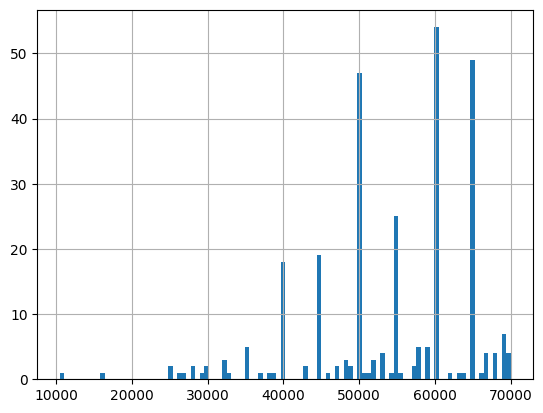

In [44]:
df[df['car_price']<70000]['car_price'].hist(bins = 100)

In [45]:
df['eng_power'].value_counts().sort_index()

eng_power
10       2
12       3
13       2
23       7
25       3
        ..
1020     9
1035     8
1197    19
1265    11
1500     7
Name: count, Length: 512, dtype: int64

In [46]:
df[df['eng_power']>800].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
23375,https://auto.ru/cars/used/sale/dongfeng/mengsh...,Dongfeng,MengshiM-Hero917,2023-н.в.,Внедорожник5дв.,1.5hybAT(816л.с.)4WD,2024-01-09,1121857480,11280203,Благовещенск,https://auto.ru/catalog/cars/dongfeng/mengshi_...,Назаказ,2023,0.618,синий,1.500000,816,Гибрид,M-hero,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/dongfeng/mengshi_...,Китай,J,5,5,4.987,2.080,1.935,22.100000,452.0,84.0,3.130000,3.800000,дисковые,дисковые,191.000000,6.000000,4.500000,gasoline,турбонаддув,1050.000000,4.000000
69498,https://auto.ru/cars/used/sale/promo_auto/drag...,Спортивныеавтоиреплики,Драгстер,1950-2024,Купе,2.4MT(1000л.с.),2024-01-15,1083242866,3000000,Ростов-на-Дону,https://auto.ru/catalog/cars/promo_auto/dragst...,Вналичии,1988,10.000,красный,2.400000,1000,Бензин,1опция,механическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/promo_auto/dragst...,Россия,S,2,2,4.500,1.800,1.500,12.097961,0.0,0.0,0.600000,2.041199,дисковые,дисковые,283.955277,4.767326,7.806160,unknown,нет,532.483088,4.000000
86021,https://auto.ru/cars/used/sale/tesla/model_s/1...,Tesla,ModelS,IРестайлинг2,Лифтбек,PlaidElectroAT(761.0кВт)4WD,2024-01-21,1121976739,11740000,Гомель,https://auto.ru/catalog/cars/tesla/model_s/227...,Вналичии,2022,7.500,белый,4.039626,1020,Электро,ModelS,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/tesla/model_s/227...,США,F,5,5,4.970,1.964,1.435,14.400000,793.0,0.0,2.161000,2.826448,дисковые,дисковые,322.000000,2.100000,0.000000,Electro,нет,967.000000,7.389748
6654,https://auto.ru/cars/used/sale/byd/yangwang_u8...,BYD,YangwangU8,2023-н.в.,Внедорожник5дв.,2.0hybAT(1197л.с.)4WD,2024-01-25,1122027890,20700000,Москва,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Вналичии,2023,0.010,чёрный,2.000000,1197,Гибрид,DeluxeEdition,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Китай,J,5,5,5.319,2.050,1.930,21.559420,0.0,75.0,2.066302,2.694768,дисковые,дисковые,170.320364,3.600000,5.340385,gasoline,турбонаддув,1280.000000,4.000000
6659,https://auto.ru/cars/used/sale/byd/yangwang_u8...,BYD,YangwangU8,2023-н.в.,Внедорожник5дв.,2.0hybAT(1197л.с.)4WD,2024-02-03,1122130543,20200000,Москва,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Вналичии,2023,0.011,зелёный,2.000000,1197,Гибрид,DeluxeEdition,автоматическая,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/byd/yangwang_u8/2...,Китай,J,5,5,5.319,2.050,1.930,21.559420,0.0,75.0,2.066302,2.694768,дисковые,дисковые,170.320364,3.600000,5.340385,gasoline,турбонаддув,1280.000000,4.000000


Видим, что много строк, где мощность равна нулю или около него, так же есть выборы, где мощность более 1000

<Axes: >

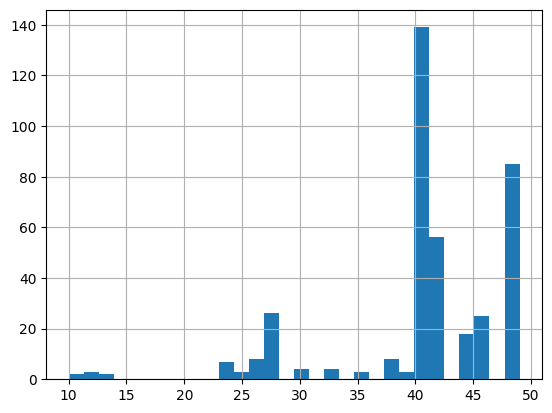

In [47]:
df[df['eng_power']<50]['eng_power'].hist(bins = 30)

In [48]:
df[df['eng_power']<50].head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
82191,https://auto.ru/cars/used/sale/subaru/sambar/1...,Subaru,Sambar,VIIРестайлинг,Микровэн,0.7MT(46л.с.)4WD,2024-01-01,1121810889,1150000,Солнечногорск,https://auto.ru/catalog/cars/subaru/sambar/231...,Вналичии,2019,68.0,белый,0.7,46,Бензин,2опции,механическая,полный,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/sambar/231...,Япония,M,5,4,3.395,1.475,1.875,16.0,0.0,40.0,0.96000,1.430000,дисковые,барабанные,181.868359,12.27384,6.100000,gasoline,нет,60.0,3.0
82106,https://auto.ru/cars/used/sale/subaru/sambar/1...,Subaru,Sambar,VIIРестайлинг,Микровэн,0.7MT(46л.с.)4WD,2024-01-01,1121811833,1150000,Солнечногорск,https://auto.ru/catalog/cars/subaru/sambar/231...,Вналичии,2019,108.0,белый,0.7,46,Бензин,8опций,механическая,полный,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/sambar/231...,Япония,M,5,4,3.395,1.475,1.875,16.0,0.0,40.0,0.96000,1.430000,дисковые,барабанные,181.868359,12.27384,6.100000,gasoline,нет,60.0,3.0
57160,https://auto.ru/cars/used/sale/moscvich/400/11...,Москвич,400,1946-1956,Кабриолет,400-4201.1MT(23л.с.),2024-01-03,1121820769,1650000,Санкт-Петербург,https://auto.ru/catalog/cars/moscvich/400/2035...,Вналичии,1950,0.5,красный,1.1,23,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/moscvich/400/2035...,Россия,C,4,4,3.855,1.400,1.555,20.0,0.0,31.0,0.88500,1.155000,барабанные,барабанные,90.000000,11.02200,5.112871,gasoline,нет,55.0,4.0
84304,https://auto.ru/cars/used/sale/suzuki/every/11...,Suzuki,Every,V,Микровэн,0.7AT(49л.с.),2024-01-05,1121827288,470000,Иркутск,https://auto.ru/catalog/cars/suzuki/every/2172...,Вналичии,2012,180.0,серебристый,0.7,49,Бензин,1опция,автоматическая,задний,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/suzuki/every/2172...,Япония,M,5,4,3.395,1.475,1.790,15.0,0.0,40.0,1.58162,2.293851,дисковые,барабанные,181.868359,12.27384,4.994833,gasoline,нет,62.0,3.0
100125,https://auto.ru/cars/used/sale/zaz/968/1121829...,ЗАЗ,968,1972-1994,Седан2дв.,М1.2MT(40л.с.),2024-01-05,1121829946,135000,Томск,https://auto.ru/catalog/cars/zaz/968/20265169/...,Вналичии,1979,43.0,жёлтый,1.2,40,Бензин,1опция,механическая,задний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/zaz/968/20265169/...,Украина,B,2,4,3.730,1.535,1.370,17.5,0.0,40.0,0.86000,1.180000,барабанные,барабанные,118.000000,35.00000,6.500000,gasoline,нет,74.0,4.0


Заметили что есть автомобили с малой мощностью двигателя, но это нормально так как это гибридный автомобиль

Также видим что у нас присутствуют старые автомобили, предлагаю проанализировать их

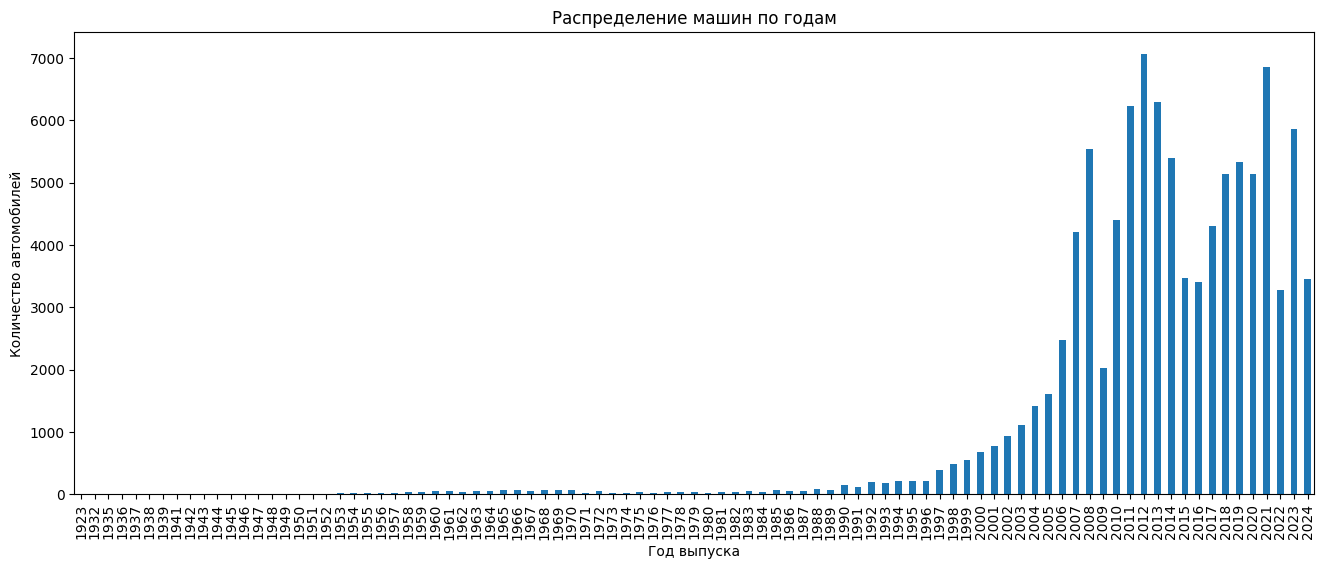

In [49]:
year_dist = df['year'].value_counts().sort_index()
plt.figure(figsize=(16, 6))
year_dist.plot(kind='bar')
plt.title('Распределение машин по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество автомобилей')
plt.show()

In [50]:
df[df['year'] >= 1970]

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,turbocharg,max_torq,cyl_count
90596,https://auto.ru/cars/used/sale/uaz/3151/112181...,УАЗ,3151,1985-2013,Внедорожник5дв.,315192.9MT(84л.с.)4WD,2024-01-01,1121811096,500000,Чехов,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Вналичии,2005,125.000,серебристый,2.9,84,Бензин,2опции,механическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/uaz/3151/7869981/...,Россия,J,5,7,4.025,1.785,2.020,22.0,900.0,78.0,1.750,2.500,дисковые,барабанные,120.000000,13.23339,16.200000,gasoline,нет,189.0,4.0
63615,https://auto.ru/cars/used/sale/peugeot/308/112...,Peugeot,308,IРестайлинг,Хэтчбек5дв.,1.6AT(120л.с.),2024-01-01,1121810455,550000,Москва,https://auto.ru/catalog/cars/peugeot/308/73527...,Вналичии,2011,100.000,белый,1.6,120,Бензин,Allure,автоматическая,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/308/73527...,Франция,C,5,5,4.276,1.815,1.498,17.0,348.0,60.0,1.312,1.835,дисковые,дисковые,188.000000,13.00000,5.400000,gasoline,нет,160.0,4.0
35146,https://auto.ru/cars/used/sale/kaiyi/e5/112181...,Kaiyi,E5,2021-н.в.,Седан,1.5CVT(147л.с.),2024-01-01,1121812001,1850000,Сочи,https://auto.ru/catalog/cars/kaiyi/e5/23390390...,Вналичии,2023,23.332,белый,1.5,147,Бензин,Luxury+,вариатор,передний,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto.ru/catalog/cars/kaiyi/e5/23390390...,Китай,C,4,5,4.670,1.825,1.483,16.0,450.0,50.0,1.441,1.797,дисковые,дисковые,210.000000,10.50000,6.146452,gasoline,турбонаддув,210.0,4.0
24079,https://auto.ru/cars/used/sale/exeed/vx/112181...,EXEED,VX,I,Внедорожник5дв.,2.0AMT(249л.с.)4WD,2024-01-01,1121812044,3750000,Аксай,https://auto.ru/catalog/cars/exeed/vx/23115309...,Вналичии,2022,12.000,фиолетовый,2.0,249,Бензин,1опция,роботизированная,полный,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/exeed/vx/23115309...,Китай,E,5,7,4.970,1.940,1.788,20.0,520.0,65.0,1.983,2.438,дисковые,дисковые,195.000000,8.50000,7.300000,gasoline,турбонаддув,385.0,4.0
82191,https://auto.ru/cars/used/sale/subaru/sambar/1...,Subaru,Sambar,VIIРестайлинг,Микровэн,0.7MT(46л.с.)4WD,2024-01-01,1121810889,1150000,Солнечногорск,https://auto.ru/catalog/cars/subaru/sambar/231...,Вналичии,2019,68.000,белый,0.7,46,Бензин,2опции,механическая,полный,Правый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/sambar/231...,Япония,M,5,4,3.395,1.475,1.875,16.0,0.0,40.0,0.960,1.430,дисковые,барабанные,181.868359,12.27384,6.100000,gasoline,нет,60.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64756,https://auto.ru/cars/used/sale/peugeot/travell...,Peugeot,Traveller,I,МинивэнLong,Long1.6dMT(115л.с.),2024-12-31,1117745242,3048262,Минск,https://auto.ru/catalog/cars/peugeot/traveller...,Вналичии,2017,204.000,чёрный,1.6,115,Дизель,1опция,механическая,передний,Левый,Нетребуетремонта,1владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/peugeot/traveller...,Франция,M,5,6,5.308,1.920,1.905,15.0,989.0,69.0,1.611,2.730,дисковые,дисковые,160.000000,13.40000,5.000000,diesel,турбонаддув,300.0,4.0
40584,https://auto.ru/cars/used/sale/land_rover/rang...,LandRover,RangeRoverSport,I,Внедорожник5дв.,3.6dAT(272л.с.)4WD,2024-12-31,1121808855,1399000,Кореновск,https://auto.ru/catalog/cars/land_rover/range_...,Вналичии,2006,213.000,синий,3.6,272,Дизель,HSE,автоматическая,полный,Левый,Нетребуетремонта,3илиболее,Оригинал,Растаможен,https://auto

Обработаю часть стобцов, чтобы в дальнейшем удобно работать с кодированием

In [51]:
print('Удалено данных:', f"{1-len(df)/len1:.2%}", 'или', len1- len(df), 'строк')   

Удалено данных: 0.00% или 0 строк


### 1.2 Подготовка к обучению

Линейная модель со стандартизацией признаков:

In [52]:
label_columns = ['car_make', 'car_model', 'car_type', 'state_mark', 'class_auto']

ordinal_columns = ['color', 'ann_city']  

ohe_columns = ['eng_type', 'transmission', 'drive', 'st_wheel',
               'count_owner', 'original_pts', 'front_brakes',
                'rear_brakes', 'turbocharg', 'fuel_brand', 'avail', 'condition' ]

df_ohe = pd.get_dummies(df, columns=ohe_columns, drop_first=True)


label_encoder = LabelEncoder()
for col in label_columns:
    df_ohe[col] = label_encoder.fit_transform(df_ohe[col])


ordinal_encoder = OrdinalEncoder()
df_ohe[ordinal_columns] = ordinal_encoder.fit_transform(df_ohe[ordinal_columns])

# Удаление ненужных столбцов
columns_to_drop = ['url_car' , 'car_gen', 'car_compl',
        'ann_date', 'ann_id', 'ann_city', 'link_cpl',
        'mileage', 'color','options', 'customs','url_compl', 
         'door_count', 'seat_count', 'height',
         'clearence', 'v_bag', 'gross_weight', 'max_speed', 'fuel_cons']
df_ohe.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [53]:
df_ohe = df_ohe.copy()

In [54]:
X = df_ohe.drop('car_price', axis=1)
y = df_ohe['car_price']

In [55]:
df_ohe = df_ohe.replace({True: 1, False: 0})

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
df_ohe

,car_make,car_model,car_type,car_price,year,eng_size,eng_power,state_mark,class_auto,long,widht,v_tank,curb_weight,acceleration,max_torq,cyl_count,eng_type_Газ,eng_type_Гибрид,eng_type_Гибрид.газобаллонноеоборудование,eng_type_Дизель,eng_type_Электро,transmission_вариатор,transmission_механическая,transmission_роботизированная,drive_передний,drive_полный,st_wheel_Правый,count_owner_2владельца,count_owner_3илиболее,original_pts_Оригинал,front_brakes_дисковые,front_brakes_керамические,rear_brakes_дисковые,rear_brakes_керамические,turbocharg_нет,turbocharg_турбонаддув,fuel_brand_diesel,fuel_brand_gas,fuel_brand_gasoline,fuel_brand_unknown,avail_Впути,avail_Назаказ
90596,211,114,8,500000,2005,2.9,84,12,6,4.025,1.785,78.0,1.750,13.233390,189.0,4.0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0
63615,131,106,243,550000,2011,1.6,120,19,2,4.276,1.815,60.0,1.312,13.000000,160.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0
35146,82,633,169,1850000,2023,1.5,147,7,2,4.670,1.825,50.0,1.441,10.500000,210.0,4.0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0
30375,200,1890,229,650000,1954,2.1,52,12,3,4.665,1.695,55.0,1.460,10.072773,127.0,4.0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0
24079,56,1702,8,3750000,2022,2.0,249,7,4,4.970,1.940,65.0,1.983,8.500000,385.0,4.0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40584,90,1354,8,1399000,2006,3.6,272,2,6,4.790,1.930,88.0,2.575,9.200000,640.0,8.0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,1,1,0,0,0,0,0
89985,211,1233,8,1150000,2016,2.7,135,12,6,4.750,1.900,68.0,2.125,20.000000,217.0,4.0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0
6088,21,1774,8,3980000,2017,3.0,360,3,3,4.708,1.891,65.0,1.810,4.800000,500.0,6.0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0
17112,38,411,237,450000,2006,1.6,109,19,2,4.274,1.769,60.0,1.275,13.100000,147.0,4.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0


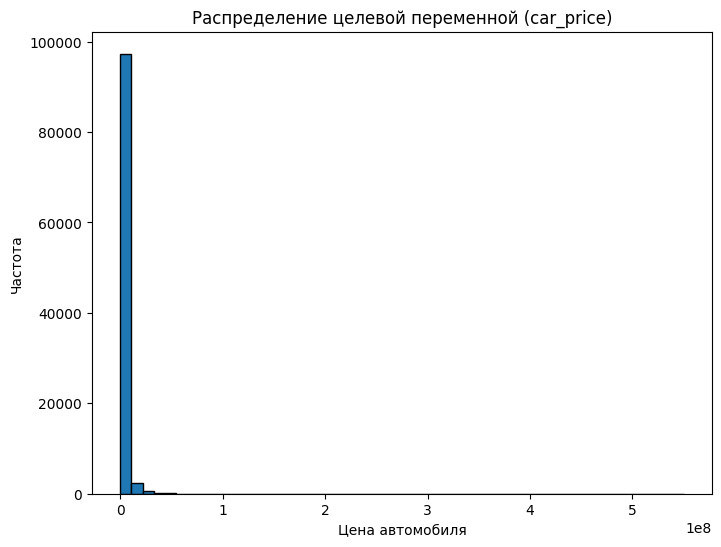

,count,mean,std,min,25%,50%,75%,max
car_make,100725.0,107.211258,55.088095,0.000,67.000,111.000,157.000,211.000
car_model,100725.0,936.685034,525.350087,0.000,475.000,976.000,1353.000,1897.000
car_type,100725.0,95.654336,90.850950,0.000,8.000,78.000,169.000,263.000
year,100725.0,2013.222556,8.643518,1923.000,2010.000,2014.000,2019.000,2024.000
eng_size,100725.0,2.149094,0.926888,0.200,1.600,2.000,2.500,8.300
eng_power,100725.0,182.203465,116.003748,10.000,112.000,150.000,211.000,1500.000
state_mark,100725.0,13.798938,7.952247,0.000,7.000,14.000,22.000,23.000
class_auto,100725.0,3.143827,1.895903,0.000,2.000,3.000,4.000,9.000
long,100725.0,4.561354,0.380264,2.488,4.350,4.595,4.803,6.330
widht,100725.0,1.822788,0.111003,1.000,1.765,1.820,1.885,2.360


In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=50, edgecolor='k')
plt.title('Распределение целевой переменной (car_price)')
plt.xlabel('Цена автомобиля')
plt.ylabel('Частота')
plt.show()

X.describe().T

Смещение вправо: Распределение цены автомобилей сильно скошено вправо, что говорит о наличии большого числа автомобилей с относительно низкой стоимостью, а также нескольких автомобилей с очень высокой стоимостью. Что логично в моем случае т.к. есть такие модели авто. Можно попробовать применить логарифмическое преобразование к цене автомобилей перед обучением модели и сравнить.

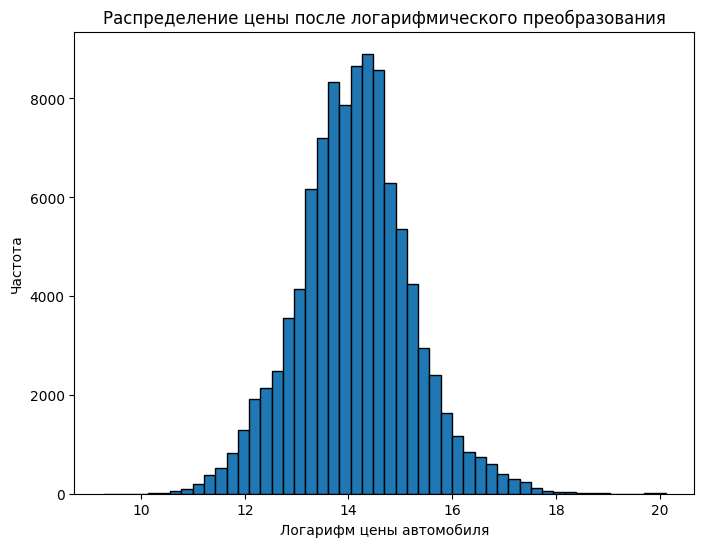

In [59]:
y_log = np.log1p(y)
plt.figure(figsize=(8, 6))
plt.hist(y_log, bins=50, edgecolor='black')
plt.title('Распределение цены после логарифмического преобразования')
plt.xlabel('Логарифм цены автомобиля')
plt.ylabel('Частота')
plt.show()

## Обучение моделей



### LinearRegression


In [60]:
%%time

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coeffs_lr = model_lr.coef_
coeffs_df_lr = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_lr}).sort_values(by='Веса', ascending=False)


y_train_pred = model_lr.predict(X_train_scaled)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print('Linear Regression:')
print('R^2 (train):', r2_train)
print('MSE (train):', mse_train)
print('R^2 (test):', r2)
print('MSE (test):', mse)
print(coeffs_df_lr)

Linear Regression:
R^2 (train): 0.42972873733068195
MSE (train): 21610438600540.555
R^2 (test): 0.3861238631828925
MSE (test): 35336546471362.36
                                      Признак          Веса
5                                   eng_power  3.393678e+06
14                                  cyl_count  1.777510e+06
34                     turbocharg_турбонаддув  1.374454e+06
33                             turbocharg_нет  1.238738e+06
3                                        year  8.482760e+05
12                               acceleration  7.238355e+05
9                                       widht  4.771721e+05
32                   rear_brakes_керамические  3.910870e+05
7                                  class_auto  3.353823e+05
21                  transmission_механическая  2.848974e+05
30                  front_brakes_керамические  2.593870e+05
6                                  state_mark  2.108482e+05
2                                    car_type  1.675298e+05
23             

### LinearRegression с логарифмическим преобразованим

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model_log = LinearRegression()
model_log.fit(X_train_scaled, y_train_log)

y_pred_log = model_log.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)

r2_log = r2_score(y_test, y_pred)
mse_log = mean_squared_error(y_test, y_pred)

coeffs_log = model_log.coef_
coeffs_df_log = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_log}).sort_values(by='Веса', ascending=False)


y_train_pred_log = model_log.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

r2_train_log = r2_score(y_train, y_train_pred)
mse_train_log = mean_squared_error(y_train, y_train_pred)

print('Linear Regression (log):')
print('R^2 (train):', r2_train_log)
print('MSE (train):', mse_train_log)
print('R^2 (test):', r2_log)
print('MSE (test):', mse_log)
print(coeffs_df_log)

Linear Regression (log):
R^2 (train): 0.656664974779366
MSE (train): 13010686260457.691
R^2 (test): 0.6203629291615831
MSE (test): 21853045250283.715
                                      Признак          Веса
3                                        year  4.671092e-01
5                                   eng_power  2.179272e-01
9                                       widht  1.693473e-01
34                     turbocharg_турбонаддув  1.270174e-01
4                                    eng_size  9.995127e-02
33                             turbocharg_нет  7.877620e-02
7                                  class_auto  7.806007e-02
31                       rear_brakes_дисковые  7.676402e-02
11                                curb_weight  5.564396e-02
0                                    car_make  4.543257e-02
6                                  state_mark  3.852839e-02
28                      original_pts_Оригинал  3.496911e-02
14                                  cyl_count  3.269450e-02
25        

 Выводы

 Логарифмическая регрессия показывает лучший показатель \( R^2 \)
- \( R^2 \): 0.749 против 0.646 в обычной линейной регрессии.
- Это свидетельствует о лучшем объяснении дисперсии целевой переменной моделью.

 Преимущества логарифмического преобразования
- Логарифмическое преобразование устраняет сильное смещение распределения целевой переменной.
- Уменьшает влияние выбросов, что способствует повышению точности модели.

Важные признаки
- Оба подхода выделяют важность следующих признаков: `fuel_brand_gas`, `year`, `eng_power`, `car_make`



### Модель Lasso с кросс валидацией со стандартизацией признаков

In [63]:
%%time

grid = {'alpha': np.logspace(-3, 6, 50)}
lasso = Lasso(random_state=42, max_iter=700)
grid_search = GridSearchCV(estimator = lasso, 
                           param_grid = grid, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=-1
                           )

grid_search.fit(X_train_scaled, y_train)
lasso_grid_model = grid_search.best_estimator_

y_pred = lasso_grid_model.predict(X_train_scaled)
r2_lasso_grid = r2_score(y_train, y_pred)
mse_lasso_grid = mean_squared_error(y_train, y_pred)

print('Lasso_cross:')
print('R^2:' , r2_lasso_grid)
print('MSE:' , mse_lasso_grid)
print('best_params:', grid_search.best_params_)


Lasso_cross:
R^2: 0.63818748683068
MSE: 1813846117450.6257
best_params: {'alpha': 212.09508879201925}
CPU times: total: 3.28 s
Wall time: 1min 1s


In [64]:
%%time

grid_elastic = {'alpha': np.logspace(-3, 6, 100),
                'l1_ratio': np.linspace(0.1 , 1, 30) 
}

elastic = ElasticNet(random_state=42)

grid_search_elastic = GridSearchCV(
        estimator = elastic, 
        param_grid = grid_elastic, 
        scoring = 'r2',
        cv = 4, 
        n_jobs = -1, 
        verbose = 1
)

grid_search_elastic.fit(X_train_scaled, y_train)
grid_model_elastic = grid_search_elastic.best_estimator_

y_pred = grid_model_elastic.predict(X_train_scaled)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

coeffs_elast_grid = grid_model_elastic.coef_
coeffs_df_log = pd.DataFrame({'Признак': X.columns, 'Веса': coeffs_elast_grid}).sort_values(by='Веса', ascending=False)

print('ElasticNet:')
print('R^2:' , r2)
print('MSE:' , mse)
print('best_params:', grid_search_elastic.best_params_)
print(coeffs_df_log)

Fitting 4 folds for each of 3000 candidates, totalling 12000 fits
ElasticNet:
R^2: 0.6381482502773883
MSE: 1814042818966.6313
best_params: {'alpha': 0.006579332246575682, 'l1_ratio': 0.6275862068965516}
                                      Признак           Веса
13                                   max_torq  938216.167371
3                                        year  776431.626036
5                                   eng_power  641796.715023
33                             turbocharg_нет  369811.076327
14                                  cyl_count  264254.555750
34                     turbocharg_турбонаддув  229633.277458
9                                       widht  118583.666670
2                                    car_type  118241.639200
7                                  class_auto  114271.401047
38                         fuel_brand_unknown  108971.118731
6                                  state_mark   47029.301073
28                      original_pts_Оригинал   41665.617284
37  

### Ridge:

In [65]:
%%time

grid_ridge = {'alpha': np.logspace(-5, 6, 100)}

ridge = Ridge(random_state=42)
grid_search_ridge = GridSearchCV(estimator = ridge, 
                                 param_grid = grid_ridge, 
                                 scoring = 'r2', 
                                 cv = 4
                                 )

grid_search_ridge.fit(X_train_scaled, y_train)
grid_model_ridge = grid_search_ridge.best_estimator_

y_pred = grid_model_ridge.predict(X_train_scaled)
r2_ridg = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

print('Ridge:')
print('R^2:' , r2)
print('MSE:' , mse)
print('best_params:', grid_search_ridge.best_params_['alpha'])

Ridge:
R^2: 0.6381482502773883
MSE: 1813978344160.9595
best_params: 129.15496650148827
CPU times: total: 2.72 s
Wall time: 11.9 s


### LightGBM 

In [62]:
%%time

lgb_model = LGBMRegressor(    
    n_estimators=500,
    max_depth=12,  
    min_data_in_leaf=5,
    min_gain_to_split=0.01,     
    learning_rate=0.05,
    random_state=42
    )
lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)

r2_lgb = r2_score(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

print('LightGBM:')
print('R^2:', r2_lgb)
print('MSE:', mse_lgb)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 75543, number of used features: 40
[LightGBM] [Info] Start training from score 2618078.667765
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current va

### LightGBM с использованием GridSearchCV 

In [64]:
%%time

lgb_params = {
    "max_depth": [-1, 10, 15],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 200],
    "num_leaves": [31, 50, 70],
    "min_child_samples": [5, 10, 20],
    "min_child_weight": [1e-3, 1e-2],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "lambda_l1": [0.0, 0.1],
    "lambda_l2": [0.0, 0.1],
}

lgb_model = LGBMRegressor(random_state=42, verbose=0)

lgb_grid_model = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_params,
    cv=4,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

lgb_grid_model.fit(X_train_scaled, y_train)

best_model_lgb_grid = lgb_grid_model.best_estimator_

y_pred_lgb_test = best_model_lgb_grid.predict(X_test_scaled)
y_pred_lgb_train = best_model_lgb_grid.predict(X_train_scaled)

r2_test_lgb_grid = r2_score(y_test, y_pred_lgb_test)
mse_test_lgb_grid = mean_squared_error(y_test, y_pred_lgb_test)

r2_train_lgb_grid = r2_score(y_train, y_pred_lgb_train)
mse_train_lgb_grid = mean_squared_error(y_train, y_pred_lgb_train)


print('LightGBM_grid Best Parameters:', lgb_grid_model.best_params_)
print('R^2 (train):', r2_train_lgb_grid )
print('MSE (train):', mse_train_lgb_grid)
print('R^2 (test):', r2_test_lgb_grid)
print('MSE (test):', mse_test_lgb_grid)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Curre

 Разница между треин и  тест (LightGBM с GridSearchCV)

In [65]:
r2_diff_lgb_grid = r2_train_lgb_grid - r2_test_lgb_grid
mse_diff_lgb_grid = mse_train_lgb_grid - mse_test_lgb_grid

print('Разница R^2 (train - test):', r2_diff_lgb_grid)
print('Разница MSE (train - test):', mse_diff_lgb_grid)


Разница R^2 (train - test): 0.013090988920758106
Разница MSE (train - test): -17134431017.597061


ВАжность признаков (LightGBM с GridSearchCV)

In [66]:
feature_importances_lgb_grid = best_model_lgb_grid.feature_importances_
feature_importances_df_lgb_grid = pd.DataFrame({'Признак': X.columns, 'Важность': feature_importances_lgb_grid}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_lgb_grid)

                          Признак  Важность
3                            year       861
11                    curb_weight       593
8                            long       545
5                       eng_power       484
12                   acceleration       465
9                           widht       382
1                       car_model       338
13                       max_torq       328
2                        car_type       279
4                        eng_size       242
6                      state_mark       231
10                         v_tank       227
0                        car_make       213
36                  avail_Назаказ       167
7                      class_auto        88
24                st_wheel_Правый        78
25         count_owner_2владельца        67
20      transmission_механическая        66
22                 drive_передний        58
26          count_owner_3илиболее        50
23                   drive_полный        42
19          transmission_вариато

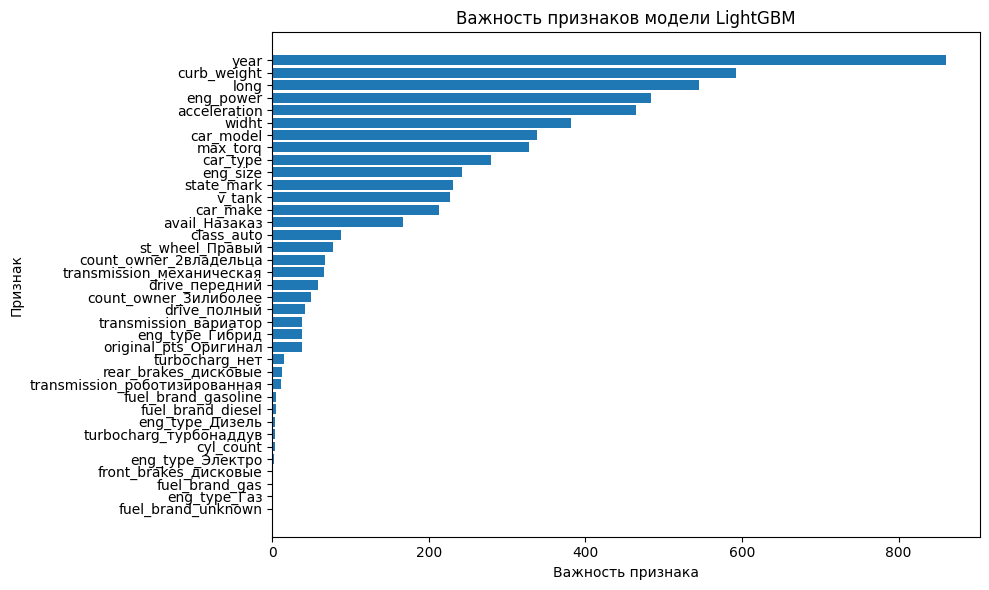

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_lgb_grid['Признак'], feature_importances_df_lgb_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков модели LightGBM с GridSearchCV')
plt.tight_layout()
plt.show()



### Random Forest

In [63]:
%%time

rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=11, 
    random_state=42  
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
feature_importances_rf = rf_model.feature_importances_
feature_importances_df_rf = pd.DataFrame({'Признак': X_train.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)

print("Random Forest:")
print("R^2:", r2_rf)
print("MSE:", mse_rf)


Random Forest:
R^2: 0.7510889406370225
MSE: 14328065042600.582
CPU times: total: 2min 30s
Wall time: 3min 14s


Важность признаков (Random Forest)

In [69]:
feature_importances_rf = rf_model.feature_importances_
feature_importances_df_rf = pd.DataFrame({'Признак': X_train.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_rf)

                          Признак      Важность
3                            year  4.581245e-01
11                    curb_weight  2.344371e-01
9                           widht  1.065708e-01
5                       eng_power  6.232233e-02
4                        eng_size  2.522497e-02
13                       max_torq  2.025451e-02
6                      state_mark  1.820015e-02
8                            long  1.066760e-02
0                        car_make  1.024114e-02
10                         v_tank  9.946432e-03
2                        car_type  9.346596e-03
12                   acceleration  7.584927e-03
36                  avail_Назаказ  6.772800e-03
1                       car_model  6.208415e-03
7                      class_auto  2.324672e-03
25         count_owner_2владельца  1.614071e-03
24                st_wheel_Правый  1.422142e-03
16                eng_type_Гибрид  1.269703e-03
20      transmission_механическая  1.160089e-03
23                   drive_полный  1.156

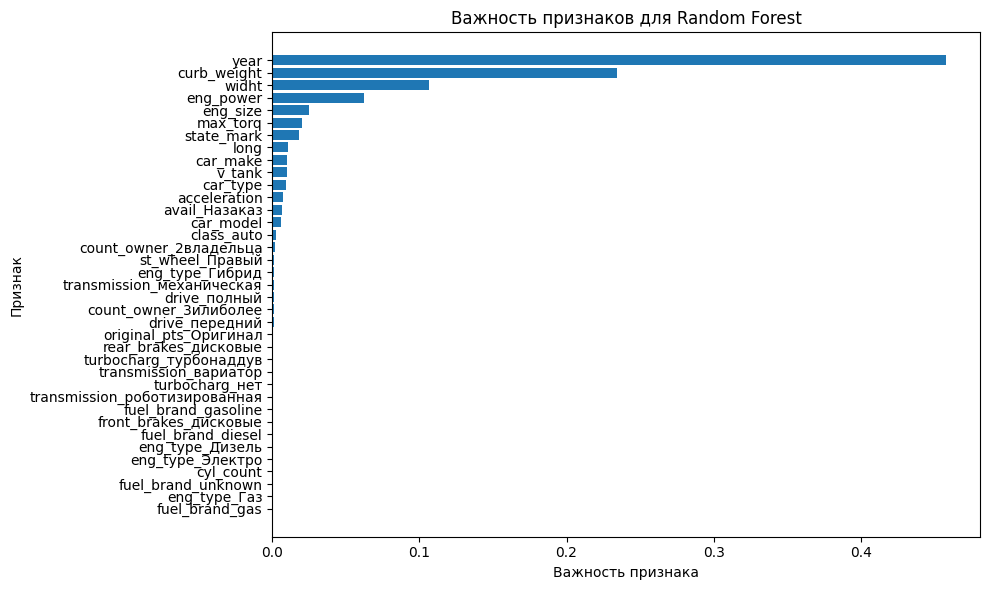

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf['Признак'], feature_importances_df_rf['Важность'], align='center')
plt.gca().invert_yaxis()  # Наиболее важные признаки сверху
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для Random Forest')
plt.tight_layout()
plt.show()



### RandomForestRegressor c использованием GridSearchCV

In [73]:
%%time

rf_grid_param = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_model = RandomForestRegressor(random_state=42, verbose=0)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid_param,
    cv=4,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model_rf_grid = grid_search.best_estimator_

y_pred_train_rf_grid = best_model_rf_grid.predict(X_train_scaled)

y_pred_test_rf_grid = best_model_rf_grid.predict(X_test_scaled)

r2_train_rfg = r2_score(y_train, y_pred_train_rf_grid)
mse_train_rfg = mean_squared_error(y_train, y_pred_train_rf_grid)

r2_test_rfg = r2_score(y_test, y_pred_test_rf_grid)
mse_test_rfg = mean_squared_error(y_test, y_pred_test_rf_grid)


print("Random_Forest_grid:")
print("Лучшие параметры:", grid_search.best_params_)
print("R^2 (train):", r2_train_rfg)
print("MSE (train):", mse_train_rfg)
print("R^2 (test):", r2_test_rfg)
print("MSE (test):", mse_test_rfg)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Random_Forest_grid:
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
R^2 (train): 0.9610130638734657
MSE (train): 51583663416.59749
R^2 (test): 0.9364160053488065
MSE (test): 83931936276.53127
CPU times: total: 22.8 s
Wall time: 6min 33s


 Разница между треин и  тест (RandomForestRegressor c GridSearchCV)

In [74]:
r2_diff_rfg = r2_train_rfg - r2_test_rfg
mse_diff_rfg = mse_train_rfg - mse_test_rfg

print('Разница R^2 (train - test):', r2_diff_rfg)
print('Разница MSE (train - test):', mse_diff_rfg)

Разница R^2 (train - test): 0.02459705852465921
Разница MSE (train - test): -32348272859.933777


Важность признаков (RandomForestRegressor c GridSearchCV)

In [75]:
feature_importances_rf_grid = best_model_rf_grid.feature_importances_
feature_importances_df_rf_grid = pd.DataFrame({'Признак': X.columns,'Важность': feature_importances_rf}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_rf_grid)

                          Признак      Важность
3                            year  4.581245e-01
11                    curb_weight  2.344371e-01
9                           widht  1.065708e-01
5                       eng_power  6.232233e-02
4                        eng_size  2.522497e-02
13                       max_torq  2.025451e-02
6                      state_mark  1.820015e-02
8                            long  1.066760e-02
0                        car_make  1.024114e-02
10                         v_tank  9.946432e-03
2                        car_type  9.346596e-03
12                   acceleration  7.584927e-03
36                  avail_Назаказ  6.772800e-03
1                       car_model  6.208415e-03
7                      class_auto  2.324672e-03
25         count_owner_2владельца  1.614071e-03
24                st_wheel_Правый  1.422142e-03
16                eng_type_Гибрид  1.269703e-03
20      transmission_механическая  1.160089e-03
23                   drive_полный  1.156

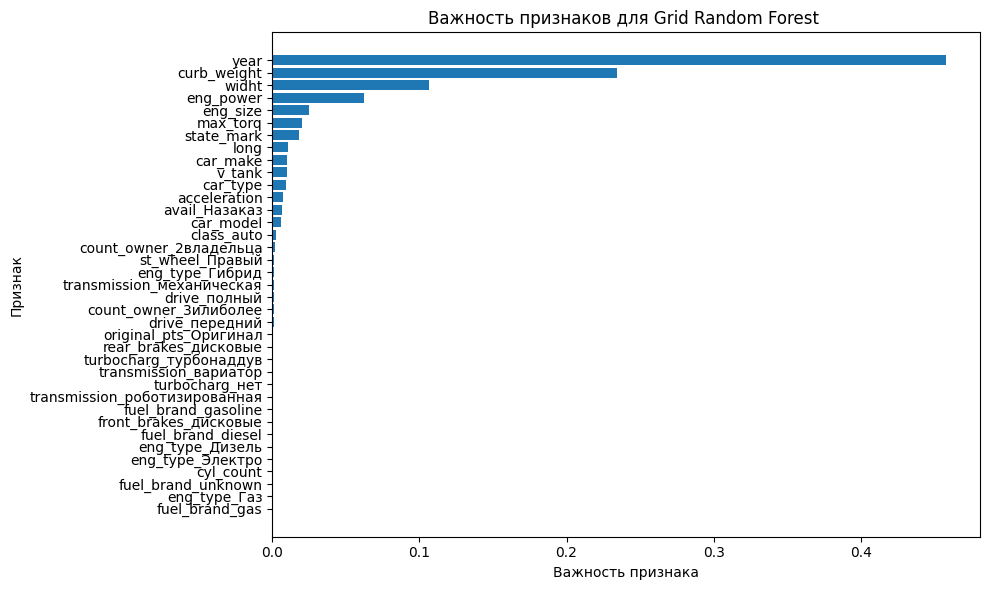

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf_grid['Признак'], feature_importances_df_rf_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для модели Random Forest c GridSearchCV ')
plt.tight_layout()
plt.show()

### CatBoost

In [64]:
%%time

cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train_scaled, y_train)

y_pred_cat = cat_model.predict(X_test_scaled)
feature_importances_cat = cat_model.get_feature_importance()

feature_importances_df_cat = pd.DataFrame({'Признак': X.columns, 'Важность': feature_importances_cat}).sort_values(by='Важность', ascending=False)

print('CatBoost:')
print('R^2:', r2_score(y_test, y_pred_cat))
print('MSE:', mean_squared_error(y_test, y_pred_cat))
print(feature_importances_df_cat)

CatBoost:
R^2: 0.7387568534440614
MSE: 15037936865347.121
                                      Признак   Важность
14                                  cyl_count  25.738456
3                                        year  20.098276
5                                   eng_power  12.617005
4                                    eng_size  10.816317
6                                  state_mark   7.661374
13                                   max_torq   3.639317
11                                curb_weight   2.759022
12                               acceleration   1.971676
0                                    car_make   1.936177
10                                     v_tank   1.872867
9                                       widht   1.777804
8                                        long   1.731640
7                                  class_auto   1.436334
29                      front_brakes_дисковые   1.412831
1                                   car_model   1.074016
2                             

### CatBoost с использованием GridSearchCV

In [65]:
%%time

cat_grid_param = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [6],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.1, 0.5, 1],
    'border_count': [32, 64]
}

cat_grid_model = CatBoostRegressor(verbose=0, random_state=42)

grid_search = GridSearchCV(
    estimator=cat_grid_model,
    param_grid=cat_grid_param,
    cv=4,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model_cat_grid = grid_search.best_estimator_

best_model_cat_grid.fit(X_train_scaled, y_train)

y_pred_test_cat_grid = best_model_cat_grid.predict(X_test_scaled)
y_pred_train_cat_grid = best_model_cat_grid.predict(X_train_scaled)


mse_train_cat_grid = mean_squared_error(y_train, y_pred_train_cat_grid)
r2_train_cat_grid = r2_score(y_train, y_pred_train_cat_grid)

r2_test_cat_grid = r2_score(y_test, y_pred_test_cat_grid)
mse_test_cat_grid = mean_squared_error(y_test, y_pred_test_cat_grid)


print('Лучшие параметры:', best_model_cat_grid.get_params())
print('CatBoost Grid:')
print('R^2 (train):', r2_train_cat_grid)
print('MSE (train):', mse_train_cat_grid)
print('R^2 (test):', r2_test_cat_grid)
print('MSE (test):', mse_test_cat_grid)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Лучшие параметры: {'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42, 'bagging_temperature': 0.1, 'border_count': 64, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoost Grid:
R^2 (train): 0.9824607682420724
MSE (train): 664649467397.648
R^2 (test): 0.7614259213088714
MSE (test): 13733037518353.955
CPU times: total: 3.12 s
Wall time: 1min 25s


 Разница между треин и  тест (CatBoost c GridSearchCV)

In [ ]:
r2_diff_catr = r2_train_cat_grid - r2_test_cat_grid
mse_diff_catr = mse_train_cat_grid - mse_test_cat_grid

print('Разница R^2 (train - test):', r2_diff_catr)
print('Разница MSE (train - test):', mse_diff_catr)

Разница R^2 (train - test): 0.01451606427856389
Разница MSE (train - test): -19020599557.66162


Важность признаков (CatBoost с GridSearchCV)

In [ ]:
feature_importances_cat_grid = best_model_cat_grid.get_feature_importance()
feature_importances_df_cat_grid = pd.DataFrame({'Признак': X.columns,'Важность': feature_importances_cat_grid}).sort_values(by='Важность', ascending=False)
print(feature_importances_df_cat_grid)

                          Признак   Важность
3                            year  43.784331
11                    curb_weight  10.810022
6                      state_mark   6.427626
4                        eng_size   5.899670
9                           widht   4.758502
5                       eng_power   4.567345
0                        car_make   4.380511
13                       max_torq   3.871103
12                   acceleration   3.743336
2                        car_type   2.592807
36                  avail_Назаказ   2.286957
1                       car_model   1.761375
10                         v_tank   0.752875
23                   drive_полный   0.714434
8                            long   0.670386
7                      class_auto   0.528782
20      transmission_механическая   0.458745
32              fuel_brand_diesel   0.370813
30                 turbocharg_нет   0.343259
29           rear_brakes_дисковые   0.307718
26          count_owner_3илиболее   0.245901
24        

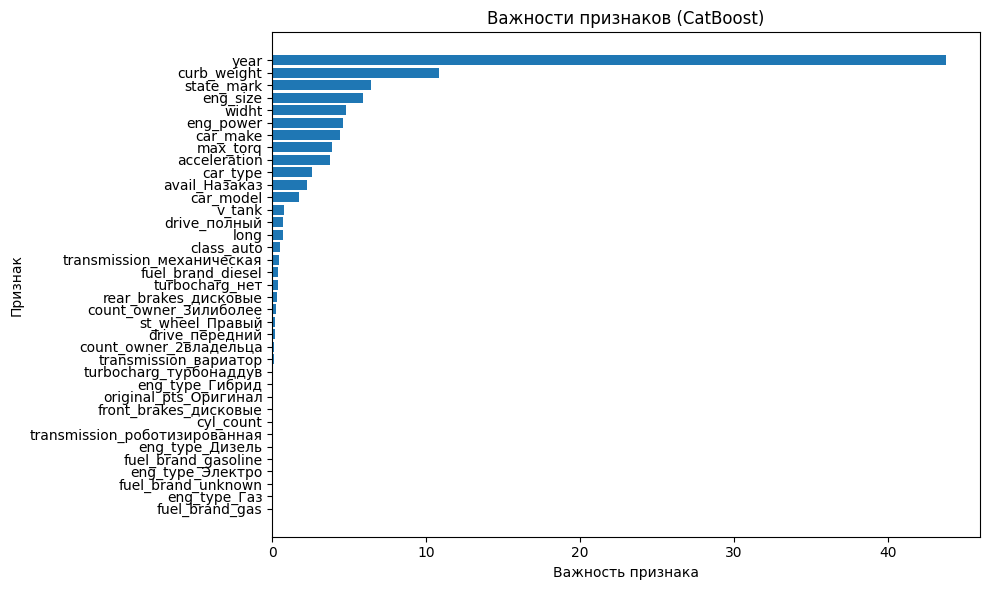

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_cat_grid['Признак'], feature_importances_df_cat_grid['Важность'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важности признаков (CatBoost)')
plt.tight_layout()
plt.show()